# MAPD - B

# Data Processing 

### Authors

+ Andrea Nicolai (1233407)
+ Sandeep Kumar Shekhar (1236227)

# Remote Cluster Setup

In order to set up a remote cluster, we thought of the following architecture:

![Architecture](images/cluster.jpg)

One should consider that the **HEAD** node acts both as the scheduler and as a worker, therefore we refer to it as "master+slave", even though it might not be the most correct definition.



With each worker having 4 VCPUs, 8GB RAM, and accessible only through a private key *my_key.pem* stored on the laptop. Once instantiated, the *public key* was downloaded from CloudVeneto and copied to the gateway into the authorized keys, in order to be able to access it **without the need of password**. The same was done also for every single node of the computing cluster:

```
#to copy the public key to the SCHEDULER/HEAD node
scp -i ~/.ssh/my_key.pem key.pub ubuntu@10.67.22.208:~/
cat key.pub >> .ssh/authorized_keys
exit
```

### Packages requirement

To avoid the mismatch of the versions which could lead to some problems, and exploiting the fact that the code was already run in a *working* **virtual** (local) environment made *ad hoc* by the means of **pipenv**, we thought of the following solution.

By running:

`
pip freeze > requirements.txt
`

One obtains "a picture" of every packages installed in the virtual environment and its dependencies, thus being able to replicate it everywhere else by locking them. This file now can be used by a `pip` command, which install the packages at the provided versions, namely: 

`
pip install -r requirements.txt
`

The only action left to do, is then to copy the file into each node.

However, since some more packages needed to run the cluster through SSH, we added them manually in a shell script (that we will present below) used to "initialize" the cluster. This is very similar to the concept of *Dockerfiles* for building images, or alternatively (and more precisely) the `bootstrap.sh` scripts one has to provide to nodes of AWS EMR clusters to set them up with the proper packages, and that is from where we got inspiration from.

### Bootstrapping Shell Script

In order to automatize as much as possible the node initialization according to some scripting, the following `bootstrap.sh` was created, and copied to every machine along with the requirements file (the base was `ubuntu-focal fossa`):

```
#!/bin/sh

sudo apt-get update -y
sudo apt install python3-pip -y
export PATH="/home/ubuntu/.local/bin:$PATH"
pip install testresources
pip install paramiko
pip install asyncssh
pip install -r requirements.txt
```

Where *testresources*, *paramiko* and *asyncssh* packages were not needed to run the cluster locally and therefore had to be added in a second time, once we discovered they were actually needed.

By simply accessing the path of the file, on each node, and by running:

`
source bootstrap.sh
`

We will have a working node ready for use.

### Port forwarding

Finally, we procedeed to keep the connection *localhost <--> gateway* always opened in the background, in order map some ports of the **HEAD** node to some of the **localhost** machine, thus being forwarded.

In other words, it consists in creating a secure tunnel from your **local** machine *(A)* to the **remote** one *(C)*. However, *C* lies in a private network, and it can be accessed only through a **gateway** *(B)*. 

The following code opens a connection with the gateway *(B)*, and associates a local port of *(A)* with the *ssh* default port (namely 22) of *(C)*:

`
ssh -L 9998:10.67.22.208:22 -N -f -i ~/.ssh/my_key.pem user@gate.cloudveneto.it
`

Finally, here we can use the local port 9998 and access *(B)*, thus setting up a tunnel which allows us to use both *Jupyter notebook* and inspect *Dask scheduler dashboard* remotely on *(C)*:

`
ssh -L 8000:localhost:8887 -L 8001:localhost:8787 -p 9998 ubuntu@localhost -i ~/.ssh/my_key.pem
`

Indeed we will be able to work on the Jupyter Notebook by accessing `http://localhost:8000` (once we remotely run `jupyter notebook --no-browser --port=8887`), while to see Dask scheduler *dashboard* through `http://localhost:8001` once the *ssh-cluster* has been instantiated. 

All the last commands can be "automatized" through editing the `~/.ssh/config` file in the following way:

```
Host the-gateway
        Hostname gate.cloudveneto.it
        Port 22
        User user
        IdentityFile ~/.ssh/my_key.pem
        LocalForward 9998 10.67.22.208:22

Host remote
        Hostname localhost
        User ubuntu
        Port 9998
        IdentityFile ~/.ssh/my_key.pem
        LocalForward 8000 localhost:8887
        LocalForward 8001 localhost:8787
```

hence by running `ssh the-gateway -f -N` will be a shortcut for the first command we wrote, whereas `ssh remote` will be an alias for the second one.



# Analysis of Covid-19 papers

### Introduction
Since this year our activities are determined by the COVID-19 pandemic, the distributed
computing project will be focused on the analysis of 1000 papers about COVID-19, SARS-CoV-2, and related corona viruses. The dataset is a sub-sample of 1000 items taken from
the original dataset that is composed of more than 75000 papers. This dataset is a part
of real-world research on COVID-19 named COVID-19 Open Research Dataset Challenge
(CORD-19). The research and related challenges are available on the dedicated page on
Kaggle: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

### JSON schema of full text documents
```
{
    "paper_id": <str>,                      # 40-character sha1 of the PDF
    "metadata": {
        "title": <str>,
        "authors": [                        # list of author dicts, in order
            {
                "first": <str>,
                "middle": <list of str>,
                "last": <str>,
                "suffix": <str>,
                "affiliation": <dict>,
                "email": <str>
            },
            ...
        ],
        "abstract": [                       # list of paragraphs in the abstract
            {
                "text": <str>,
                "cite_spans": [             # list of character indices of inline citations
                                            # e.g. citation "[7]" occurs at positions 151-154 in "text"
                                            #      linked to bibliography entry BIBREF3
                    {
                        "start": 151,
                        "end": 154,
                        "text": "[7]",
                        "ref_id": "BIBREF3"
                    },
                    ...
                ],
                "ref_spans": <list of dicts similar to cite_spans>,     # e.g. inline reference to "Table 1"
                "section": "Abstract"
            },
            ...
        ],
        "body_text": [                      # list of paragraphs in full body
                                            # paragraph dicts look the same as above
            {
                "text": <str>,
                "cite_spans": [],
                "ref_spans": [],
                "eq_spans": [],
                "section": "Introduction"
            },
            ...
            {
                ...,
                "section": "Conclusion"
            }
        ],
        "bib_entries": {
            "BIBREF0": {
                "ref_id": <str>,
                "title": <str>,
                "authors": <list of dict>       # same structure as earlier,
                                                # but without `affiliation` or `email`
                "year": <int>,
                "venue": <str>,
                "volume": <str>,
                "issn": <str>,
                "pages": <str>,
                "other_ids": {
                    "DOI": [
                        <str>
                    ]
                }
            },
            "BIBREF1": {},
            ...
            "BIBREF25": {}
        },
        "ref_entries":
            "FIGREF0": {
                "text": <str>,                  # figure caption text
                "type": "figure"
            },
            ...
            "TABREF13": {
                "text": <str>,                  # table caption text
                "type": "table"
            }
        },
        "back_matter": <list of dict>           # same structure as body_text
    }
}
```


## Assignment

#### Word counter distributed algorithm
First of all, you have to implement the following distributed algorithm to count the occurrences of all the words inside a list of documents. In NLP (Natural Language Processing) a documents is a text, in this case, each paper is a document. The algorithm is defined as follow:
+ **Map phase** : For each document $D_i$, produce the set of intermediate pairs $(w, c_p(w))$, one for each word $w \in D_i$, where $c_p(w)$ is the number of occurrences of $w$ in $D_i$.
E.g.: (*hello*, 3)
+ **Reduce phase** : For each word $w$, gather all the previous pairs $(w, c_p(w))$ and return the final pair $(w, c(w))$ where $c(w)$ is the number of occurrences of $w$ for all the Documents. In other words, $c(w)$ is equal to $\sum_{k=1}^n c_{p_k}(w)$

The algorithm has be run on the full-text of the papers. To get the full text of the paper you have to transform the input data by concatenating the strings contained into the body-text fields of the JSONs.

To perform this transformation I strongly suggest you use the Bag data-structure of DASK. Anyway if you prefer to implement the algorithm by using the DataFrame structure feel free to do it. The **algorithm** has be **run several times** by changing the number of workers and the number of partitions. For each run the **execution time must be registered**. Provide a comment
on how change the computation time over the cluster by changing the partitions and the number of workers.

You have to try with at least 6 different partition numbers. At the end of the algorithm analyze the top words and see how they are related to the viruses and the research (for example create a barplot of the top words)

In [1]:
import json
import dask
import time
import os
import warnings
import re
import sys
import string
import itertools
import gensim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import dask_histogram as dh
import bokeh.palettes as palette
import seaborn as sns

from dask.distributed import Client
from dask.distributed import LocalCluster
from nltk.corpus import stopwords
from pathlib import Path
from nltk.tokenize import WhitespaceTokenizer
word_tokenize = WhitespaceTokenizer()

### Local cluster

The cluster was run locally, setting 4 threads per worker, in order to emulate the VMs provided by Cloud Veneto, but for now exploiting all 32 cores of the machine. However, parameters will be changed later

In [2]:
n_workers = 8
n_threads = 4

###### INITIALIZE THE CLUSTER
cluster = LocalCluster(n_workers = n_workers, threads_per_worker = n_threads)
client = Client(cluster)
warnings.filterwarnings('ignore')

client

<Client: 'tcp://127.0.0.1:41457' processes=8 threads=32, memory=23.49 GiB>

### Remote cluster

The cluster has been already instantiated from CLI command line with different number of workers and the scheduler being on the **HEAD** node, namely:

+ **5 Workers** : `dask-ssh 10.67.22.208 10.67.22.102 10.67.22.178 10.67.22.117 10.67.22.85 --ssh-private-key ~/.ssh/my_key.pem --ssh-username ubuntu`
+ **4 Workers** : `dask-ssh 10.67.22.208 10.67.22.102 10.67.22.178 10.67.22.117 --ssh-private-key ~/.ssh/my_key.pem --ssh-username ubuntu`
+ **3 Workers** : `dask-ssh 10.67.22.208 10.67.22.102 10.67.22.178 --ssh-private-key ~/.ssh/my_key.pem --ssh-username ubuntu`
+ **2 Workers** : `dask-ssh 10.67.22.208 10.67.22.102  --ssh-private-key ~/.ssh/my_key.pem --ssh-username ubuntu`
+ **1 Workers** : `dask-ssh 10.67.22.208 --ssh-private-key ~/.ssh/my_key.pem --ssh-username ubuntu`

With workers having 4 threads each.

Note as we pass as arguments the path to *private key* in order to be able to communicate between nodes without the need of any password, as well the *ubuntu* username.

One problem we faced is that Security Group rules were not enough, even though the firewall of every machine was disabled via `sudo ufw disable`, so we thought it could have been a matter of some firewalls from the Infrastructure side.
Hence *pod students* rules were added, thus allowing instances to connect between each other from any port (and not only through the standard *ssh*, i.e. 22).

We have seen that if:
+ *No* VM instance had *pod student*: cluster could not be instantiated, since machines (in particular the scheduler node) could not contact each other and connection was hanging.
+ *Only* the **HEAD** node had *pod student* group rule: cluster could be instantiated successfully, but at the moments of retrieving the work done, the scheduler was hanging not receiving anything since ports, from worker side, were closed.
+ *All* nodes had *pod student* group rule: cluster could be instantiated since **HEAD** could connect to workers, and moreover workers were able to successfully send the work done. 

More precisely, default security group rules already present:

**default**:

`
CONSENTI IPv4 icmp from 0.0.0.0/0
CONSENTI IPv4 22/tcp from 0.0.0.0/0
CONSENTI IPv4 to 0.0.0.0/0
CONSENTI IPv4 icmp from 0.0.0.0/0
CONSENTI IPv4 22/tcp from 0.0.0.0/0
CONSENTI IPv6 to ::/0
`

Which essentially allow only to connect via *ssh* to/from every instance, but do **not** allow **incoming** connections through every other ports using *tcp* protocol, that is exactly what we require to make the cluster successfully communicate. These are the reason why te following security group rules contained in *pod-students* are needed (in particular, the third line):

**pod-students**:

`
CONSENTI IPv4 tcp to 0.0.0.0/0
CONSENTI IPv4 to 0.0.0.0/0
CONSENTI IPv4 tcp from 0.0.0.0/0
CONSENTI IPv6 to ::/0
`

In [ ]:
#Retrieve the cluster, which has been already instantiated
client = Client("tcp://10.67.22.208:8786")
warnings.filterwarnings('ignore')

client

That results in the following output:
![Output of previous command](images/img_client.png)


In [3]:
print("Python Version : ", sys.version)
print("Dask Version : ", dask.__version__)

Python Version :  3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
Dask Version :  2021.06.0


#### Import files.

In [2]:
#handle directories creation and files listing
path_to_preproc_files = "data/preprocessed/"
path_to_files         = !ls data/papers_in_json/*.json
preproc_files         = !ls data/preprocessed/*.json
filenames_list        = !cd data/papers_in_json && ls *.json

Path(path_to_preproc_files).mkdir(parents = True, exist_ok = True)

In [3]:
preproc_files[0:5]

['data/preprocessed/000a0fc8bbef80410199e690191dc3076a290117.json',
 'data/preprocessed/000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a.json',
 'data/preprocessed/000b0174f992cb326a891f756d4ae5531f2845f7.json',
 'data/preprocessed/000b7d1517ceebb34e1e3e817695b6de03e2fa78.json',
 'data/preprocessed/000bc3d4637530496ac4cb798e10d95709eff92d.json']

#### PrePre-processing code

Convert the json file to a 1-line json, otherwise `json.loads` cannot work properly. Essentially it is neeeded to neglect characters `\n` and `\t`, or else it would raise an eror.

In [6]:
index = 0
for file, filename in zip(path_to_files, filenames_list):
    
    #open the file to read from
    file_op = open(file,"r")
    #open the file to write to
    target = open(path_to_preproc_files+filename,"w+")

    file_stream = file_op.read()
    file_stream = file_stream.replace('\t','')
    file_stream = file_stream.replace('\n','')
    
    target.write( str( re.split("[\n]", file_stream )[0]) )

    #close the two files
    target.close()
    file_op.close()

The following block of code is *only* for the **remote cluster**, since we want to send all the data needed to the workers, taking care it has to be on a **unique path**. 

+ `!scp -i ~/.ssh/Andrea_Nicolai.pem -r data ubuntu@10.67.22.102:~/`
+ `!scp -i ~/.ssh/Andrea_Nicolai.pem -r data ubuntu@10.67.22.178:~/`
+ `!scp -i ~/.ssh/Andrea_Nicolai.pem -r data ubuntu@10.67.22.117:~/`
+ `!scp -i ~/.ssh/Andrea_Nicolai.pem -r data ubuntu@10.67.22.85:~/`

#### Global scope variables for defining stopwords and patterns to be removed

In [4]:
my_stopwords = stopwords.words('english') + ['fig', 'et', 'al', 'ml', 'also', 'however',
                                             'may', 'using', 'used', 'one', 'e', 'figure', 'due',
                                             'while', 'fdr', 'fc', 'could', 'seq', 'pfswib',
                                             'use', 'two', 'that', 'which', 'would']

#patterns generated by using https://regex-generator.olafneumann.org/
patterns = {
           'digits': re.compile('[0-9]+'),
           'ref' : re.compile('\[[\d]+\]'),
           'punctuation': re.compile(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~><-]*'),
           'urls': re.compile('(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)'),
           'stop_words_patt' : re.compile(r'\b(' + r'|'.join(my_stopwords) + r')\b\s*')
            }

Function definitions for:
+ Distributed preprocessing of data
+ Map phase 
+ Reduce phase

In [5]:
################
#   MAP PHASE  #
################

#take every paragraph from a document and merge them together, thus obtaining the full text which is concatenated
def text_join(full_text):
    return ' '.join([par['text'] for par in full_text])

#function to clean the text from the patterns we have
def clean_text(full_text):
    
    #remove references
    text = patterns.get('ref').sub(' ', full_text)
    
    #remove stopwords
    text = patterns.get('stop_words_patt').sub('', text)
    
    #remove digits
    text = patterns.get('digits').sub(' ', text)

    #remove urls
    text = patterns.get('urls').sub(' ', text)
    
    #remove punctuation
    text = patterns.get('punctuation').sub('', text)
    
    return text

def count_words(text):
#function to count unique words in a text, it returns a dictionary of the kind 
#{word1: n_occurr_word1, word2: n_occurr_word2 etc.} 
    unique_words = {}
    for single_word in text:
        #setdefault: works as "set" but for dictionaries:
        # if a key (i.e. single_word) is not present, thus meaning it has not been encountered yet, then add it to the dictionary with "0" value
        # if a key is already present, then go to next line
        unique_words.setdefault(single_word, 0)
        unique_words[single_word] += 1
    return unique_words

###################
#   REDUCE PHASE  #
###################

# For each word gather all the previous pairs and return the final pair
# where is the number of occurrences of for all the Documents.
def merge_sets(setA, setB):
    return {key : setA.get(key, 0) + setB.get(key, 0) for key in setA.keys() | setB.keys()}


####################
# PROFILING FUNCT. #
####################

#this function returns first "n_items" elements of a dictionary
def slice_dictionary(my_dict: dict, n_items: int):
    return dict(itertools.islice(my_dict.items(), n_items))

The next blocks code provides an example step-by-step of how our algorithm will work.

In [16]:
#read the files
js_files = db.read_text(preproc_files).map(json.loads)
js_files.take(1)

({'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'metadata': {'title': 'PfSWIB, a potential chromatin regulator for var gene regulation and parasite development in Plasmodium falciparum',
   'authors': [{'first': 'Wei-Feng',
     'middle': [],
     'last': 'Wang',
     'suffix': '',
     'affiliation': {'laboratory': '',
      'institution': 'Second Military Medical University',
      'location': {'postCode': '200433',
       'settlement': 'Shanghai',
       'country': 'China'}},
     'email': ''},
    {'first': 'Yi-Long',
     'middle': [],
     'last': 'Zhang',
     'suffix': '',
     'affiliation': {'laboratory': '',
      'institution': 'Second Military Medical University',
      'location': {'postCode': '200433',
       'settlement': 'Shanghai',
       'country': 'China'}},
     'email': ''}]},
  'abstract': [{'text': 'Background: Various transcription factors are involved in the process of mutually exclusive expression and clonal variation of the Plasmodium multigene (

In [10]:
#full-text concatenation to retrieve the whole text of the paper (which is contained in "body_text")
js_files_text = js_files.pluck("body_text").map(text_join)
js_files_text.take(1)

('Plasmodium falciparum, which causes malignant malaria such as cerebral malaria (CM) or pregnancy-associated malaria (PAM) [1, 2] , is the cause of death to 435,000 individuals annually [3] . Plasmodium falciparum erythrocyte membrane protein 1 (PfEMP1), which is encoded by the var gene family comprising approximately 60 members, is the major virulence factor involved in the antigenic variation and clinical pathogenicity of falciparum malaria [4, 5] . It is remarkable that the expression of var family members is mutually exclusive. For each parasite at a time, only one or a few var genes are expressed, while the remaining members are silenced [6, 7] . In each generation, P. falciparum is able to express different var genes, and the switches in var gene expression lead to antigenic variation of PfEMP1, which results in immune evasion and chronic infection [8] [9] [10] [11] . This process has proven to be mediated by epigenetic mechanisms, including chromatin modification, nuclear archi

In [11]:
#all characters to lower letters and text cleaning part
js_files_text_cleaned = js_files_text.map(lambda x: x.lower()).map(clean_text)
js_files_text_cleaned.take(1)

('plasmodium falciparum causes malignant malaria cerebral malaria cm pregnancyassociated malaria pam      cause death    individuals annually    plasmodium falciparum erythrocyte membrane protein   pfemp  encoded var gene family comprising approximately   members major virulence factor involved antigenic variation clinical pathogenicity falciparum malaria      remarkable expression var family members mutually exclusive parasite time var genes expressed remaining members silenced      generation falciparum able express different var genes switches var gene expression lead antigenic variation pfemp  results immune evasion chronic infection          process proven mediated epigenetic mechanisms including chromatin modification nuclear architecture gene relocation      shown single active var gene enriched euchromatic modifications histone   lysine   acetylation k ac histone   lysine   trimethylation k me  particularly near transcriptional start site tss    silent var genes usually enriche

The previous cells describe how the text we are going to analyze looks like. As one can see:
+ All letters have been casted to small ones (i.e. there are no capital letters)
+ Some pre processing has been pursued, removing patterns defined by the means of reg ex such as numbers, urls and stopwords

### MAP phase 
 + Every partition is now mapped to a dictionary that counts word occurencies in itself, thus obtaining a dictionary for every partition.

In [12]:
#word counter part
# -tokenization (i.e. cast a string to a list with all the contained words)
# -wc algorithm (MAP)
js_files_wc = js_files_text_cleaned.map(lambda text: word_tokenize.tokenize(text)).map(count_words)
js_files_wc.take(1)

({'plasmodium': 7,
  'falciparum': 29,
  'causes': 2,
  'malignant': 1,
  'malaria': 6,
  'cerebral': 1,
  'cm': 1,
  'pregnancyassociated': 1,
  'pam': 1,
  'cause': 1,
  'death': 1,
  'individuals': 1,
  'annually': 1,
  'erythrocyte': 1,
  'membrane': 1,
  'protein': 19,
  'pfemp': 3,
  'encoded': 1,
  'var': 59,
  'gene': 37,
  'family': 7,
  'comprising': 2,
  'approximately': 3,
  'members': 4,
  'major': 5,
  'virulence': 3,
  'factor': 2,
  'involved': 9,
  'antigenic': 3,
  'variation': 7,
  'clinical': 1,
  'pathogenicity': 1,
  'remarkable': 1,
  'expression': 42,
  'mutually': 2,
  'exclusive': 2,
  'parasite': 32,
  'time': 4,
  'genes': 40,
  'expressed': 12,
  'remaining': 1,
  'silenced': 1,
  'generation': 1,
  'able': 1,
  'express': 1,
  'different': 12,
  'switches': 1,
  'lead': 3,
  'results': 9,
  'immune': 2,
  'evasion': 2,
  'chronic': 1,
  'infection': 1,
  'process': 12,
  'proven': 1,
  'mediated': 2,
  'epigenetic': 2,
  'mechanisms': 2,
  'including': 6,


### REDUCE phase
 + Dictionaries, which are the output of the **mapping** phase, now must be merged together to obtain a unique dictionary

In [13]:
#here it means: 
# SOURCE: https://docs.dask.org/en/latest/bag-api.html#dask.bag.Bag.fold
# - Reduce within each partition using the "merge sets" binary operator
# - Combine the results of every partition using the "merge sets" binary operator
all_papers_wc = js_files_wc.fold(binop = merge_sets, combine = merge_sets)

In [14]:
#now we trigger the execution for all the files
word_occurrence_dictionary = all_papers_wc.compute()
word_occurrence_dictionary

{'focusedrefined': 1,
 'noac': 2,
 'batsarslikecovwiv': 2,
 'dualfluorescence': 3,
 'stomacha': 1,
 'analytecommon': 1,
 'physiologically': 37,
 'rvepcttci': 1,
 'kleinkindern': 1,
 'beneficence': 3,
 'integrin': 59,
 'dornase': 25,
 'twohybrid': 1,
 'carbonyldiimidazole': 2,
 'perforindependent': 1,
 'konzentrationen': 4,
 'empfindlicher': 1,
 'illumigen': 1,
 'radiotherapists': 1,
 'sfa': 1,
 'httptreebioedacuksoftware': 1,
 'pyrogens': 4,
 'mittelwert': 4,
 'anthocyanins': 1,
 'ctac': 2,
 'sofort': 1,
 'realstarsarscov': 1,
 'abruptonset': 1,
 'psfs': 1,
 'unregulated': 6,
 'cvalue': 1,
 'dapb': 1,
 'cladinose': 5,
 'histamineinduced': 6,
 'annualized': 1,
 'lignin': 5,
 'munition': 4,
 'corvids': 3,
 'rejections': 1,
 'resumes': 4,
 'antagonist': 83,
 'npy': 1,
 'tirm': 2,
 'xenotransplantation': 4,
 'ptubre': 1,
 'thymidine': 26,
 'diphosphates': 1,
 'dropletbased': 27,
 'mammographydm': 1,
 'taxation': 4,
 'indicates': 492,
 'cpebased': 3,
 'reptiles': 21,
 'redpurple': 1,
 'vtf'

Let us **sort** the dictionary to take a look at the words that are the most used.

In [15]:
sorted_dict = dict(sorted(word_occurrence_dictionary.items(), key=lambda x:x[1], reverse = True))
sorted_dict

{'patients': 12360,
 'cells': 11491,
 'virus': 8644,
 'infection': 7647,
 'study': 7575,
 'data': 6430,
 'viral': 6178,
 'disease': 5983,
 'cell': 5676,
 'protein': 5263,
 'results': 5255,
 'different': 4684,
 'studies': 4675,
 'time': 4600,
 'clinical': 4577,
 'human': 4282,
 'cases': 4111,
 'number': 4068,
 'covid': 4066,
 'analysis': 4037,
 'treatment': 4022,
 'group': 3969,
 'high': 3825,
 'viruses': 3823,
 'respiratory': 3727,
 'rna': 3713,
 'expression': 3713,
 'found': 3699,
 'first': 3681,
 'model': 3612,
 'control': 3602,
 'well': 3452,
 'including': 3435,
 'health': 3425,
 'associated': 3410,
 'shown': 3408,
 'system': 3373,
 'reported': 3365,
 'response': 3268,
 'proteins': 3159,
 'table': 3113,
 'compared': 3110,
 'infections': 3096,
 'influenza': 3069,
 'samples': 3065,
 'infected': 3032,
 'gene': 3015,
 'risk': 3013,
 'mice': 3001,
 'activity': 2977,
 'three': 2962,
 'significant': 2950,
 'levels': 2948,
 'important': 2931,
 'higher': 2922,
 'performed': 2921,
 'based': 2

Let us see the top 20 words with largest occurrencies

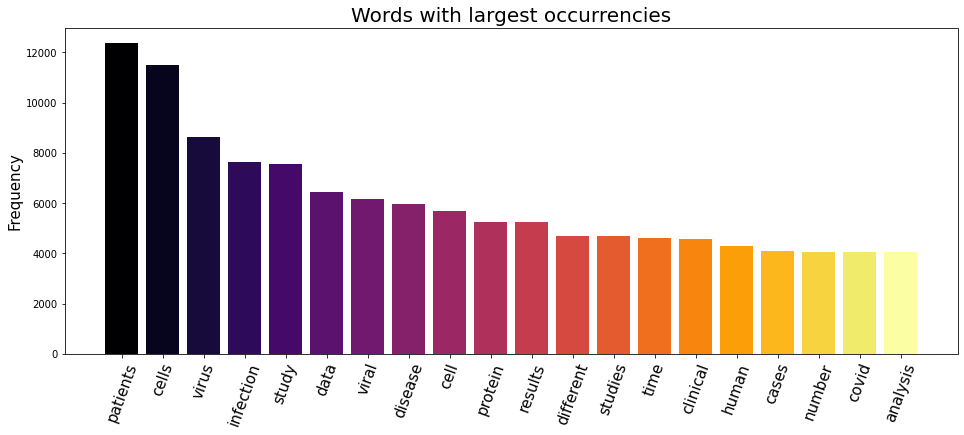

In [16]:
k = 20

top_k_words = slice_dictionary(sorted_dict, k)
fig = plt.figure(figsize = (16,6))
plt.bar(top_k_words.keys(), height = top_k_words.values(), color = palette.inferno(k))
plt.xticks(rotation=70, fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Words with largest occurrencies", fontsize = 20)
plt.show()

In [17]:
#Only for the local cluster
client.close()

# Profiling - REMOTE

At every iteration we restart the client, which, as the documentation states: kills all active work, deletes all data on the network, and restarts the worker processes so to have a *clean* cluster (i.e. no caching).

Here, the number of workers if kept **fixed**, and depends on our instantiation with the CLI, and we only iterate through different numbers of partitions.

In [ ]:
preproc_files         = !ls data/preprocessed/*.json
tot_files = 1000

n_partitions   = [1,2,5,10,25,50,10,250,500,1000]

def get_execution_time_first(files_list, n_workers = 1, n_partitions = 1000):
    #this function returns the time elapsed for running the algorithm we presented step by step earlier:
    # - over a file list we pass as parameter
    # - given a certain number of workers
    # - splitting our data into a certain number of partitions
    
    #restart the client (see above) cleaning previous executions files
    client.restart()
    
    start_time = time.time()
    
    #load the files
    js_files = db.read_text(files_list).repartition(n_partitions).map(json.loads)
    #full-text concatenation
    js_files_text = js_files.pluck("body_text").map(text_join)
    #text cleaning part
    js_files_text_cleaned = js_files_text.map(lambda x: x.lower()).map(clean_text)
    #mapping
    js_files_wc = js_files_text_cleaned.map(lambda text: word_tokenize.tokenize(text)).map(count_words)
    #reducing
    all_papers_wc = js_files_wc.fold(binop = merge_sets, combine = merge_sets).compute()
    sorted_dict = dict(sorted(all_papers_wc.items(), key=lambda x:x[1], reverse = True))
    
    end_time = time.time()
    delta = end_time - start_time
        
    return delta

# Profiling - LOCAL

Here instead we physically shutdown and recreate a local cluster with different number of workers, everyone having 4 threads, to put ourselves in the same conditions as the remote cluster, thus making the results comparable. We will iterate through 5->1 number of workers, and the same set of partitions as before.

In [6]:
preproc_files         = !ls data/preprocessed/*.json
tot_files = 1000

n_workers_list = [1,2,3,4,5]
n_partitions   = [1,2,5,10,25,50,100,250,500,1000]

# Functions for profiling
def create_cluster(n_workers = 1):
    # this function creates a Local cluster, passing as parameters
    # - the number of workers we want
    # - the number of cores our machine has
    n_threads = 4
    
    cluster = LocalCluster(n_workers = n_workers, threads_per_worker = n_threads)
    client = Client(cluster)
    
    print("Cluster is on!")
    return cluster, client

def shutdown_cluster(cluster, client):
    # this function shuts down the cluster, thus eventually saving memory
    client.close()
    cluster.close()
    return print("Cluster has been shut down!")


def get_execution_time_first(files_list, n_workers = 1, n_partitions = 1000):
    #this function returns the time elapsed for running the algorithm we presented step by step earlier:
    # - over a file list we pass as parameter
    # - given a certain number of workers
    # - splitting our data into a certain number of partitions
    
    #instantiate the cluster
    cluster, client = create_cluster(n_workers)
    start_time = time.time()
    
    #load the files
    js_files = db.read_text(files_list).repartition(n_partitions).map(json.loads)
    #full-text concatenation
    js_files_text =js_files.pluck("body_text").map(text_join)
    #text cleaning part
    js_files_text_cleaned = js_files_text.map(lambda x: x.lower()).map(clean_text)
    #mapping
    js_files_wc = js_files_text_cleaned.map(lambda text: word_tokenize.tokenize(text)).map(count_words)
    #reducing
    all_papers_wc = js_files_wc.fold(binop = merge_sets, combine = merge_sets).compute()
    sorted_dict = dict(sorted(all_papers_wc.items(), key=lambda x:x[1], reverse = True))

    end_time = time.time()
    delta = end_time - start_time
    
    shutdown_cluster(cluster, client)
    
    return delta

In [7]:
times_list = []
times_dataframe = pd.DataFrame()

for n_work in n_workers_list:
    for n_part in n_partitions:
        time_elapsed = get_execution_time_first(preproc_files, n_work, n_part)
        times_list.append(time_elapsed)
        times_dataframe = times_dataframe.append(
            {'n_workers': int(n_work),
             'n_partitions': int(n_part),
             'time': time_elapsed
            }, ignore_index=True)
        print("Number of workers: ", n_work , "Number of partitions: ", n_part, "####### Time [s]: ", time_elapsed)

times_dataframe.to_csv("times_first_df_same_conditions.csv", index = False)

Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  1 ####### Time [s]:  32.463075160980225
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  2 ####### Time [s]:  28.397712469100952
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  5 ####### Time [s]:  20.598345518112183
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  10 ####### Time [s]:  18.17786955833435
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  25 ####### Time [s]:  17.43153715133667
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  50 ####### Time [s]:  17.157485485076904
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  100 ####### Time [s]:  17.021984338760376
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  250 ####### T

Here we will present some of the **LOCAL** results, remote ones will be shown and discussed later.

In [8]:
times_dataframe_first = pd.read_csv("times_first_df_same_conditions.csv", dtype = {'n_partitions' : int, 'n_workers' : int, 'time' : float })
times_dataframe_first.head()

n_partitions  n_workers       time
0             1          1  32.463075
1             2          1  28.397712
2             5          1  20.598346
3            10          1  18.177870
4            25          1  17.431537

In [9]:
times_dataframe_first.tail()

n_partitions  n_workers       time
45            50          5  11.191338
46           100          5  11.492613
47           250          5  12.105652
48           500          5  12.609572
49          1000          5  13.391864

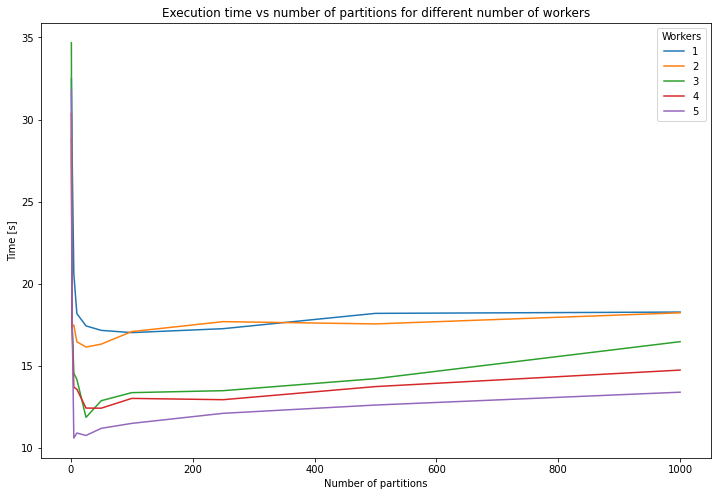

In [10]:
fig = plt.figure(figsize = (12,8))
for n_work in n_workers_list:
    subset_df = times_dataframe_first[times_dataframe_first['n_workers'] == n_work]
    plt.plot(subset_df.n_partitions, subset_df.time, label = str(n_work))

plt.xlabel("Number of partitions")
plt.ylabel("Time [s]")
plt.legend(title = "Workers")
plt.title("Execution time vs number of partitions for different number of workers")
plt.show()

Generally, the more partitions we have above a certain threshold, the more time it takes except. So somewhere there is a minimum

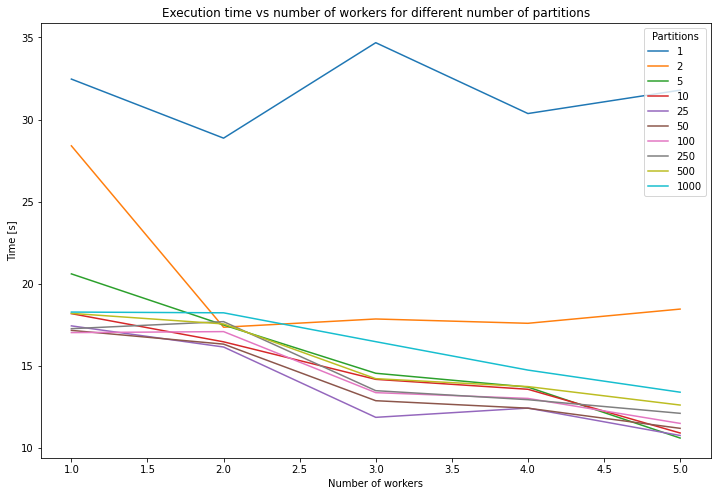

In [11]:
fig = plt.figure(figsize = (12,8))
for n_part in n_partitions:
    subset_df = times_dataframe_first[times_dataframe_first['n_partitions'] == n_part]
    plt.plot(subset_df.n_workers, subset_df.time, label = str(n_part))

plt.xlabel("Number of workers")
plt.ylabel("Time [s]")
plt.legend(title = "Partitions")
plt.title("Execution time vs number of workers for different number of partitions")
plt.show()

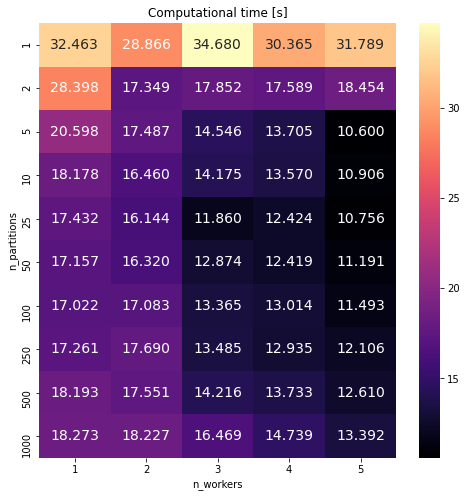

In [12]:
#heatmap code
plt.figure(figsize = (8,8))
heatmap1_data = pd.pivot_table(times_dataframe_first, values='time', 
                     index=['n_partitions'], 
                     columns='n_workers')
sns.heatmap(heatmap1_data, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f")
plt.title("Computational time [s]")
plt.show()

#### Which are the worst and best represented countries in the research?
In this part you have to take the documents and to convert them in a usable DataFrame
data structure in order to figure out the countries that are most and less active in the
research. To do this you can use the **country** of the *authors*. Do the same for the **universities** (affiliations).
Even in this case do multiple runs by changing the number of partitions and workers and
then describe the behaviour of the timings.

In [21]:
js_files = db.read_text(preproc_files).map(json.loads).pluck("metadata")
js_files.take(1)

({'title': 'PfSWIB, a potential chromatin regulator for var gene regulation and parasite development in Plasmodium falciparum',
  'authors': [{'first': 'Wei-Feng',
    'middle': [],
    'last': 'Wang',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Second Military Medical University',
     'location': {'postCode': '200433',
      'settlement': 'Shanghai',
      'country': 'China'}},
    'email': ''},
   {'first': 'Yi-Long',
    'middle': [],
    'last': 'Zhang',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Second Military Medical University',
     'location': {'postCode': '200433',
      'settlement': 'Shanghai',
      'country': 'China'}},
    'email': ''}]},)

In [22]:
def authors_institution_country_list(document):
    '''
    Extract country and university (affiliations) of the authors, thus return a list of dictionaries
    where every dictionary contains info about a single author and its country/university
    '''
    list_dict = []

    for author in document['authors']:
        author_dictionary = {'name' : author['first'] + ' ' + author['last']}
        
        
        study_place = author['affiliation']
        try:
            institution = study_place['institution']
        except:
            institution = "Unknown"
        
        try:
            country = study_place['location']['country']
        except:
            country = "Unknown"
        
        author_dictionary.update({'institution': institution})
        author_dictionary.update({'country': country})
        
        list_dict.append(author_dictionary)
        
    return list_dict 

Some of the countries are either misspelled or are equivalent to some others:

In [23]:
def remap_countries_name(country):
    '''
    Here there are basically two conditions one can see:
    - (string in country): means if "string" is CONTAINED in the list of words passed as argument of the function
    - (country == "string"): means if country is EQUAL to a certain string
    These parameters and conditions have been implemented after having already inspected the data, to remove redundant countries definition
    for every authors thus simplifying our data.
    '''
    
    if ('America' in country) | ('USA' in country) | (country == "United States, United States., Bangladesh") | ( country == "U.S.A"):
        return 'United States'
    elif (country == 'Taiwan, ROC') | ('Taiwan' in country):
        return 'Taiwan'
    elif country == 'Deutschland':
        return 'Germany'
    elif (country == 'UK') | (country == 'England') | (country == 'UK A R') | (country == "U.K") | ('UK' in country) | ('United Kingdom' in country) | (country == 'U.K.'):
        return 'United Kingdom'
    elif ('Schweden' in country):
        return 'Sweden'
    elif (country == "Brazil. R") | ("Brazil" in country) | (country == "Brasil"):
        return "Brazil"
    elif ("Singapore" in country):
        return "Singapore"
    elif ("Netherlands" in country) | ("the Netherlands" in country):
        return "Netherlands"
    elif (country == 'España') | ('España' in country)| ('Spain' in country):
        return 'Spain'
    elif ("China" in country):
        return "China"
    elif ("Korea" in country):
        return "Republic of Korea"
    elif ("India" in country):
        return "India"
    elif ("Mexico" in country):
        return "Mexico"
    elif ("France" in country):
        return "France"
    elif ("Portugal" in country):
        return "Portugal"
    elif ("Japan" in country):
        return "Japan"
    elif ("Uruguay" in country):
        return "Uruguay"
    elif ("Poland" in country):
        return "Poland"
    elif ("Australia" in country):
        return "Australia"
    elif ("Italy" in country):
        return "Italy"
    else:
        return country

In [24]:
#Convert to dataframe 
js_files = js_files.map(authors_institution_country_list).flatten().to_dataframe()
#and remap countries with the function above
js_files.country = js_files.country.map(remap_countries_name)
js_files.head()

/home/andrea/.local/share/virtualenvs/DataProcessingExam-gwCZpG-z/lib/python3.8/site-packages/dask/dataframe/core.py:6682: UserWarning: Insufficient elements for `head`. 5 elements requested, only 2 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


name                         institution country
0  Wei-Feng Wang  Second Military Medical University   China
1  Yi-Long Zhang  Second Military Medical University   China

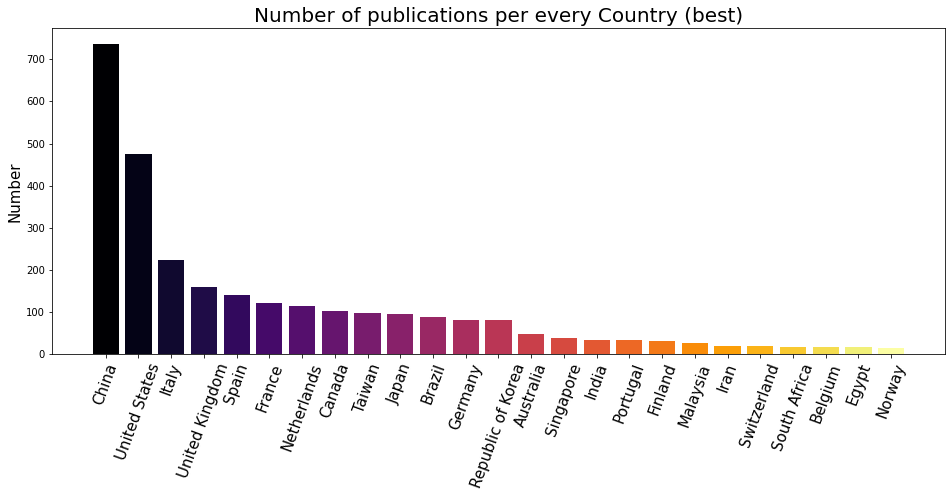

In [25]:
#select the 25 most active countries in the research against COVID-19
k = 25

#compute the most active countries
countries_dict = js_files.groupby('country').count().name.compute()
countries_dict_best = dict(sorted(countries_dict.items(), key=lambda x:x[1], reverse = True))
countries_dict_best.pop('Unknown', None)
countries_dict_best.pop('Ann Arbor', None)
top_k_countries = slice_dictionary(countries_dict_best, k)

fig = plt.figure(figsize = (16,6))
plt.bar(top_k_countries.keys(), height = top_k_countries.values(), color = palette.inferno(k))
plt.xticks(rotation=70, fontsize = 15)
plt.ylabel('Number', fontsize = 15)
plt.title("Number of pubblications per every Country (best)", fontsize = 20)
plt.show()

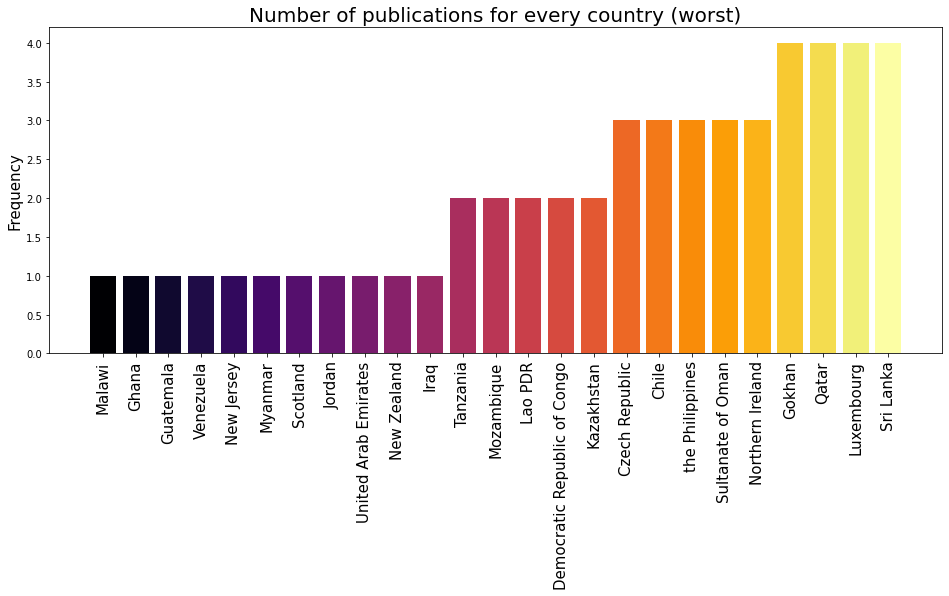

In [26]:
#compute the worst active countries
countries_dict_worst = dict(sorted(countries_dict.items(), key=lambda x:x[1], reverse = False))
countries_dict_worst.pop('Unknown', None)
countries_dict_worst.pop('Ann Arbor', None)
worst_k_countries = slice_dictionary(countries_dict_worst, k)


fig = plt.figure(figsize = (16,6))
plt.bar(worst_k_countries.keys(), height = worst_k_countries.values(), color = palette.inferno(k))
plt.xticks(rotation=90, fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Number of publications for every country (worst)", fontsize = 20)
plt.show()

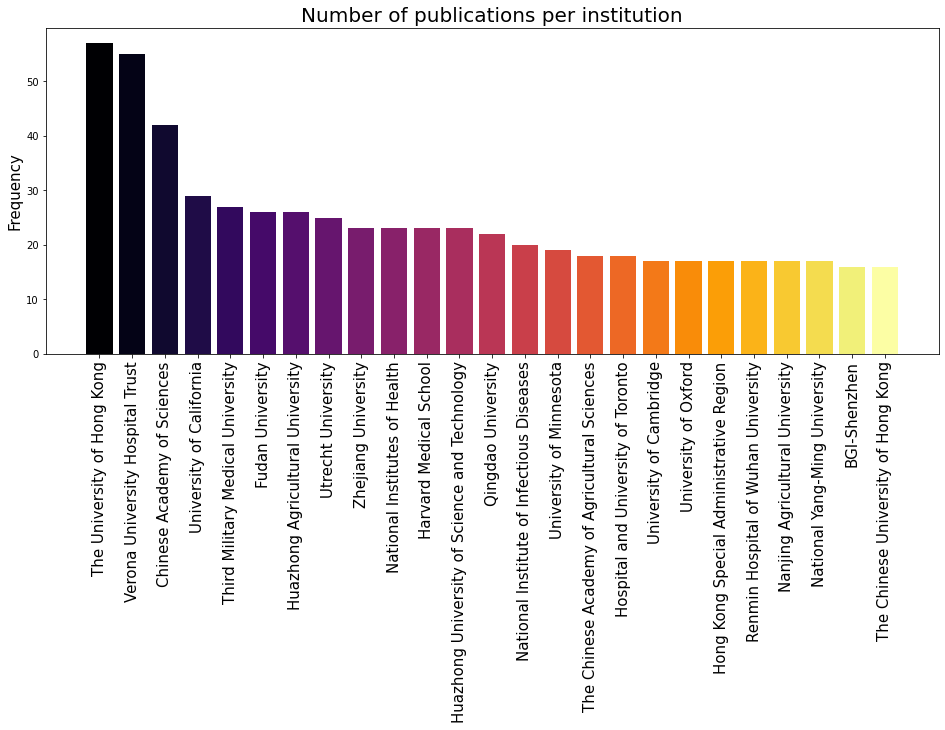

In [27]:
#compute the most active insititutions
institution_dict = js_files.groupby('institution').name.count().compute()
institution_dict_best = dict(sorted(institution_dict.items(), key=lambda x:x[1], reverse = True))
institution_dict_best.pop('Unknown', None)
institution_dict_best.pop('', None)
best_k_institutions = slice_dictionary(institution_dict_best, k)


fig = plt.figure(figsize = (16,6))
plt.bar(best_k_institutions.keys(), height = best_k_institutions.values(), color = palette.inferno(k))
plt.xticks(rotation=90, fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Number of pubblications per institution", fontsize = 20)
plt.show()

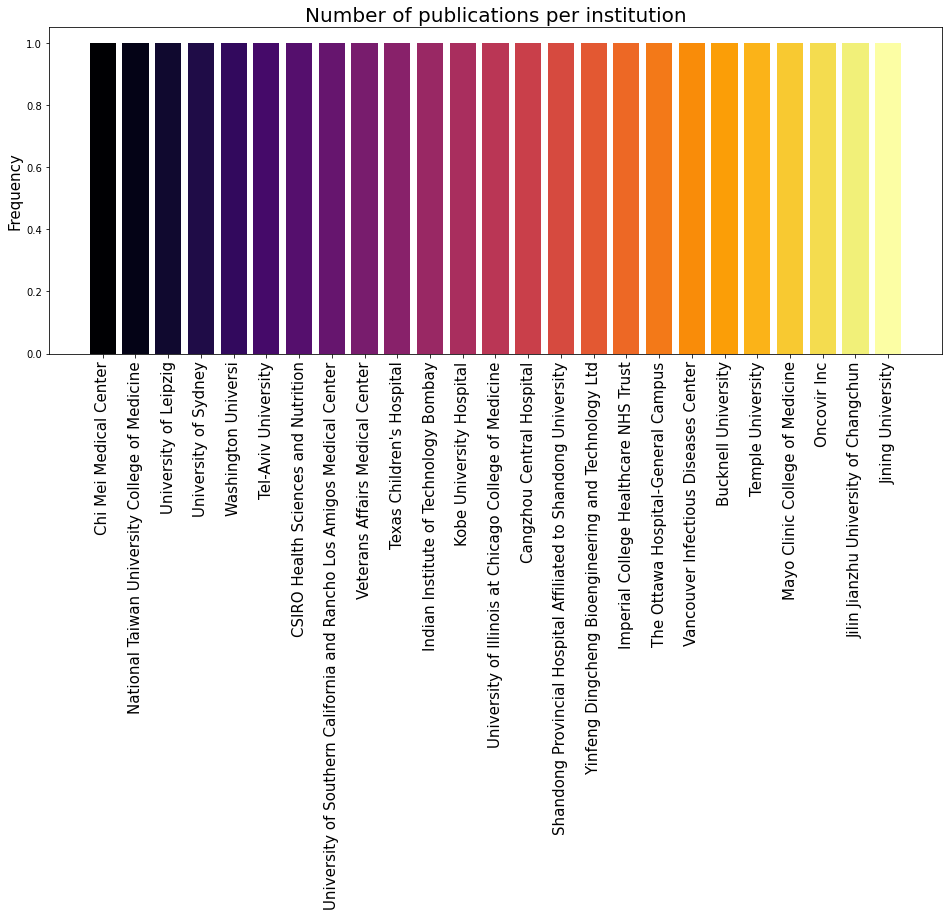

In [28]:
#compute the least active insititutions
institution_dict_worst = dict(sorted(institution_dict.items(), key=lambda x:x[1], reverse = False))
institution_dict_worst.pop('Unknown', None)
institution_dict_worst.pop('', None)
worst_k_institutions = slice_dictionary(institution_dict_worst, k)


fig = plt.figure(figsize = (16,6))
plt.bar(worst_k_institutions.keys(), height = worst_k_institutions.values(), color = palette.inferno(k))
plt.xticks(rotation=90, fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Number of publications per institution", fontsize = 20)
plt.show()

### Profiling part

The code is really similar to the one above, where we computed the words that are the most used in the papers.  

# Profiling - REMOTE

At every iteration we restart the client, which, as the documentation states: kills all active work, deletes all data on the network, and restarts the worker processes so to have a *clean* cluster.

Here, the number of workers if kept **fixed**, and depends on our instantiation with the CLI, and we only iterate through different numbers of partitions.

In [ ]:
tot_files = 1000
n_partitions   = [1,2,5,10,25,50,100,250,500,1000]


def get_execution_time_second(files_list, n_workers = 1, n_partitions = 1000):
    client.restart()
    
    start_time = time.time()
    
    #load the files
    js_files = db.read_text(files_list).repartition(n_partitions).map(json.loads).pluck("metadata")
    #Convert to dataframe and remap countries
    js_files = js_files.map(authors_institution_country_list).flatten().to_dataframe()
    js_files.country = js_files.country.map(remap_countries_name)
    
    #most/least active country-related part
    countries_dict = js_files.groupby('country').count().name.compute()
    countries_dict_best = dict(sorted(countries_dict.items(), key=lambda x:x[1], reverse = True))
    countries_dict_worst = dict(sorted(countries_dict.items(), key=lambda x:x[1], reverse = False))

    #most/least active institution-related part
    institution_dict = js_files.groupby('institution').name.count().compute()
    institution_dict_best = dict(sorted(institution_dict.items(), key=lambda x:x[1], reverse = False))
    institution_dict_worst = dict(sorted(institution_dict.items(), key=lambda x:x[1], reverse = False))

    end_time = time.time()
    delta = end_time - start_time
    
    return delta

# Profiling - LOCAL

Here instead we physically shutdown and recreate a local cluster.

In [29]:
tot_files = 1000

n_workers_list = [1,2,3,4,5]
n_partitions   = [1,2,5,10,25,50,100,250,500,1000]


def get_execution_time_second(files_list, n_workers = 1, n_partitions = 1000):
    
    cluster, client = create_cluster(n_workers)
    start_time = time.time()
    
    #load the files
    js_files = db.read_text(files_list).repartition(n_partitions).map(json.loads).pluck("metadata")
    #Convert to dataframe and remap countries
    js_files = js_files.map(authors_institution_country_list).flatten().to_dataframe()
    js_files.country = js_files.country.map(remap_countries_name)
    
    #most/least active country-related part
    countries_dict = js_files.groupby('country').count().name.compute()
    countries_dict_best = dict(sorted(countries_dict.items(), key=lambda x:x[1], reverse = True))
    countries_dict_worst = dict(sorted(countries_dict.items(), key=lambda x:x[1], reverse = False))

    #most/least active institution-related part
    institution_dict = js_files.groupby('institution').name.count().compute()
    institution_dict_best = dict(sorted(institution_dict.items(), key=lambda x:x[1], reverse = False))
    institution_dict_worst = dict(sorted(institution_dict.items(), key=lambda x:x[1], reverse = False))

    end_time = time.time()
    delta = end_time - start_time
    
    shutdown_cluster(cluster, client)
    
    return delta

In [30]:
times_list = []
times_dataframe = pd.DataFrame()

for n_work in n_workers_list:
    for n_part in n_partitions:
        time_elapsed = get_execution_time_second(preproc_files, n_work, n_part)
        times_list.append(time_elapsed)
        times_dataframe = times_dataframe.append(
            {'n_workers': int(n_work),
             'n_partitions': int(n_part),
             'time': time_elapsed
            }, ignore_index=True)
        print("Number of workers: ", n_work , "Number of partitions: ", n_part, "####### Time [s]: ", time_elapsed)
        
times_dataframe.to_csv("times_second_df_same_conditions.csv", index = False)

Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  1 ####### Time [s]:  7.891528129577637
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  2 ####### Time [s]:  8.022170066833496
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  5 ####### Time [s]:  6.645242929458618
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  10 ####### Time [s]:  6.8482584953308105
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  25 ####### Time [s]:  9.189794301986694
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  50 ####### Time [s]:  8.069459915161133
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  100 ####### Time [s]:  12.745552778244019
Cluster is on!
Cluster has been shut down!
Number of workers:  1 Number of partitions:  250 ####### Time

In [31]:
times_dataframe_second = pd.read_csv("times_second_df_same_conditions.csv", dtype = {'n_partitions' : int, 'n_workers' : int, 'time' : float })
times_dataframe_second.head()

n_partitions  n_workers      time
0             1          1  7.891528
1             2          1  8.022170
2             5          1  6.645243
3            10          1  6.848258
4            25          1  9.189794

In [32]:
times_dataframe_second.tail()

n_partitions  n_workers       time
45            50          5   3.727096
46           100          5   5.050839
47           250          5   5.565169
48           500          5   9.664978
49          1000          5  15.120722

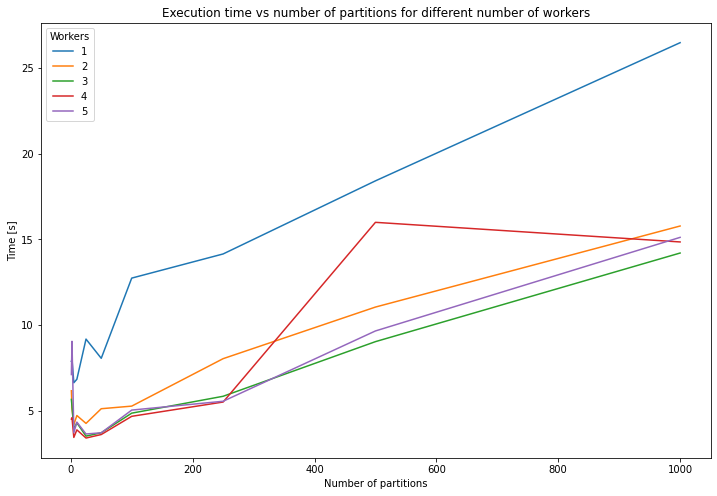

In [33]:
fig = plt.figure(figsize = (12,8))
for n_work in n_workers_list:
    subset_df = times_dataframe_second[times_dataframe_second['n_workers'] == n_work]
    plt.plot(subset_df.n_partitions, subset_df.time, label = str(n_work))

plt.xlabel("Number of partitions")
plt.ylabel("Time [s]")
plt.legend(title = "Workers")
plt.title("Execution time vs number of partitions for different number of workers")
plt.show()

As before, the larger the number of partitions our data have, the more time it generally takes.

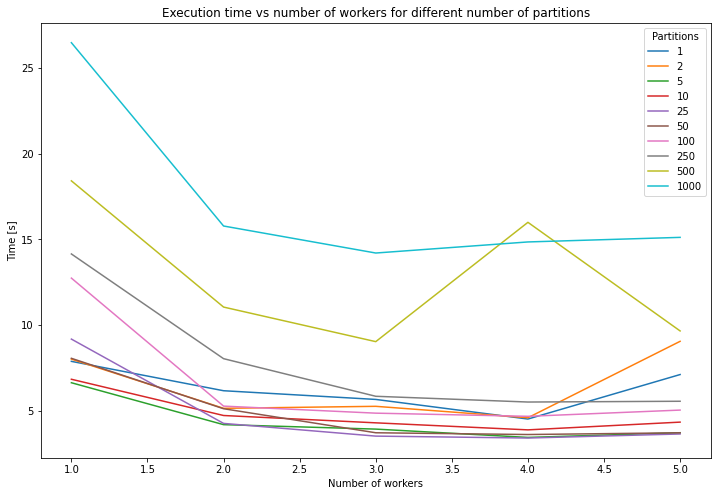

In [34]:
fig = plt.figure(figsize = (12,8))
for n_part in n_partitions:
    subset_df = times_dataframe_second[times_dataframe_second['n_partitions'] == n_part]
    plt.plot(subset_df.n_workers, subset_df.time, label = str(n_part))

plt.xlabel("Number of workers")
plt.ylabel("Time [s]")
plt.legend(title = "Partitions")
plt.title("Execution time vs number of workers for different number of partitions")
plt.show()

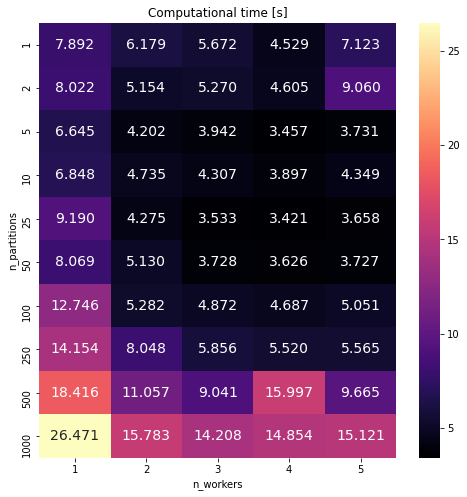

In [35]:
#heatmap code
plt.figure(figsize = (8,8))
heatmap2_data = pd.pivot_table(times_dataframe_second, values='time', 
                     index=['n_partitions'], 
                     columns='n_workers')
sns.heatmap(heatmap2_data, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f")
plt.title("Computational time [s]")
plt.show()

Here we can see as the CPU time is less when number of workers is 4, which is not the largest amount of workers available. 

#### Get the embedding for the title of the papers

In NLP a common technique to perform analysis over a set of texts is to transform the
text to a set of vectors each one representing a word inside a document. At the end of
the pre-processing the document will be transformed into a list of vectors or a matrix of
$n \times m$ where $n$ is the number of words in the document and $m$ is the size of the vector
that represents the word $n$.

More information about word-embedding: https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa
What you can do is to transform the title of the paper into its embedding version by using
the pre-trained model available on FastText page: https://fasttext.cc/docs/en/pretrained-vectors.html.
The pre-trained model that you have to download is the https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
Basically the pre-trained model is more or less a huge dictionary in the following format
$key : vector$.

To load the model follow this snippet of code which is slightly different from what you
can find at this page https://fasttext.cc/docs/en/english-vectors.html

In [41]:
def create_dictionary(doc, dictionary = {}):
    #this function returns a dictionary related to a single paper, and contains:
    # paper_id : hash of the paper
    # title : title of the paper, the try and except construct is to take into account that title might be empty
    paper_id = doc[0]
    try:
        title = doc[1].get('title')
    except:
        title = ''
    
    dictionary.update({'paper_id': paper_id, 'title': title})
    return {'paper_id': paper_id, 'title': title}

def get_embedding(sentence, model):
    #this function, given a sentence and a model, returns the embedding of a sentence that 
    #is chosen to be cleaned using the function implemented for the first part of the assignment.
    #Finally the embedding is chosen to be flatteden to a unique vector, as allowed by the assignment
    sentence = sentence.get('title').lower()
    sentence_cleaned = clean_text(sentence)
    
    word_tokenize = WhitespaceTokenizer()
    sentence_tokenized = word_tokenize.tokenize(sentence_cleaned)
    
    embedding = []
    #some words might not be present in the model, therefore we use the try/except construct
    for word in sentence_tokenized:
        try:
            word_emb = model[word]
            embedding.append(word_emb)
        except:
            continue
            
    float_array = np.ndarray.flatten(np.array(embedding))
    #needs to be casted to string or else it cannot JSONify thus being saved
    return ["%.8f" % value for value in float_array]

def save_to_file(paper_info, path):
    '''
    This function saves a JSON file for every paper, containing the paper id, its title and the embedding of the title.
    This was done to save the time needed to load everytime the model, which takes order of minutes, thus avoiding to rerun the whole code.
    '''
    fname = path + paper_info.get('paper_id') + ".json"
    with open (fname, 'w') as file:
            json.dump(paper_info, file)
    return

In [42]:
#load the model + profiling
print("Model loading")
start_time = time.time()
model = gensim.models.KeyedVectors.load_word2vec_format('wiki.en.vec')
end_time = time.time()
print("Model loading took [s] :", end_time - start_time)

Model loading
Model loading took [s] : 470.7293908596039


In [43]:
#instantiate the Local cluster
cluster, client = create_cluster(n_workers = 8) 

#path to preprocessed files, whose titles are needed
title_embeddings_path  = "data/title_embeddings/"
filename = os.path.join('data', 'preprocessed', '*.json')

Path(title_embeddings_path).mkdir(parents = True, exist_ok = True)

Cluster is on!


Once you have loaded the model, use the map approach to create a DataFrame or a Bag
that is composed by:
+ paper-id
+ title-embedding
The title embedding can be a list of vectors or can be flattened to a large vector.

In [44]:
my_dictionary = {}
Path(title_embeddings_path).mkdir(parents = True, exist_ok = True)

#save (for now) only the metadata needed
js_metadata = db.read_text(filename).map(json.loads).pluck(["paper_id", "metadata"]).compute()

Let us now create a **dask bag** with the metadata, and return a list of dictionaries, where every dictionary TEMPORARILY contains:
+ paper_id
+ title
In addition some filtering has been done to avoid large cosine similarities, introduced by some very common and uninformative titles, such as *"Supplementary appendix"*, *"Original Article*" etc...

In [45]:
js_titles_ready = (db.from_sequence(js_metadata).map(lambda doc: create_dictionary(doc, my_dictionary))
                   .filter(lambda paper: paper['title'] != 'Supplementary appendix')
                   .filter(lambda paper: paper['title'] != 'Journal Pre-proof')
                   .filter(lambda paper: paper['title'] != 'Editorial')
                   .filter(lambda paper: paper['title'] != 'case report')
                   .filter(lambda paper: paper['title'] != 'COmment')
                   .filter(lambda paper: paper['title'] != 'Original Article')
                   .filter(lambda paper: paper['title'] != '')
                   .compute())

Now we **sequentially** iterate over the list of dictionaries we have just obtained, since if keeping an eye on the RAM memory, this procedure exhausts the RAM of the worker and essentially takes too much time. A possible reason is that the Word2vec model, needed for the embedding, has to sent to all the workers in the cluster if parallelization is requested, thus soon filling the RAM. 

In [54]:
#here distributing is not the easiest way, since it exhausts the RAM memory of every worker even when worker = 1... (?)
for paper in js_titles_ready:
    paper.update({'embedding': list(np.float_(get_embedding(paper, model)))})

#save the files to avoid recomputing everything again
dummy = db.from_sequence(js_titles_ready).map(lambda paper: save_to_file(paper, title_embeddings_path)).compute()

In [47]:
print("A paper looks like the following: " )
print("{ 'paper_id' : ", js_titles_ready[7].get('paper_id'))
print(" 'title' : ", js_titles_ready[7].get('title'))
print(" 'embedding' : ", js_titles_ready[7].get('embedding')[1:10], " ... (only first 10 entries are shown)")
print(" } ")

A paper looks like the following: 
{ 'paper_id' :  00a3a4742c565f5e2e64ad03fe0f1e16baee89b3
 'title' :  Plethora of Respiratory Viruses and Respiratory Virus Data
 'embedding' :  [-0.0017225, -0.062871, 0.34003001, -0.031795, 0.071087, 0.34766999, -0.25127, -0.0055435, 0.25738999]  ... (only first 10 entries are shown)
 } 


In [48]:
shutdown_cluster(cluster, client)

Cluster has been shut down!


#### Bonus point

Use the previously generated vectors to compute the **cosine similarity** between each
paper and to figure out a couple of papers with the highest cosine similarity score.
This point is a bonus/optional point.

In [49]:
#retrieve the embeddings of the files
path_to_files  = !ls data/title_embeddings/*.json

In [50]:
def create_dataframe(paper):
    '''
    Create a list that contains dictionaries, where every dictionary has the information we need about the papers, 
    and which we computed earlier. 
    '''
    papers_list  = []
    paper_dict = {'paper_id' : paper.get('paper_id'),
                  'title': paper.get('title'), 
                  'embedding': paper.get('embedding')}
    papers_list.append( [paper.get('paper_id'), paper.get('title'),  paper.get('embedding')] )
    return papers_list


def cosine(vector1, vector2):
    '''
    Given two vectors, this function computes the cosine similarity between them.
    If the lengths of the two vectors are different, we keep only the number of common elements the two vectors have,
    in other words we keep a the number of elements that is as much as the number of elements of the shortest vector. 
    '''
    #one can use only the very first elements of the embeddings, i.e. lengths of the embeddings must coincide
    num_elem = min(len(vector1), len(vector2))
    
    #compute the norm of the two vectors (it will be the denominator)
    vec1_norm = np.linalg.norm(vector1[0:num_elem])
    vec2_norm = np.linalg.norm(vector2[0:num_elem])
    
    #if the shortest vector has no elements, returns zero, or else a NaN appears
    if num_elem == 0:
        return 0.
    
    #try and except construct is used to handle exceptions
    try:
        cosine = np.vdot(vector1[0:num_elem], vector2[0:num_elem])/(vec1_norm*vec2_norm)
    except:
        cosine = 0.
    
    return cosine

In [51]:
#create the dataframe with the data we need
cosine_df = db.read_text(path_to_files).map(json.loads).to_dataframe().compute()
#reindex the df
cosine_df.index = np.arange(0, len(cosine_df))
#cast to float the values in the list, since they are essentially strings and cannot be exploited in computations
cosine_df.embedding = cosine_df.embedding.apply(lambda row: [float(x) for x in row])
cosine_df

paper_id  \
0    000a0fc8bbef80410199e690191dc3076a290117   
1    000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a   
2    000b0174f992cb326a891f756d4ae5531f2845f7   
3    000b7d1517ceebb34e1e3e817695b6de03e2fa78   
4    000bc3d4637530496ac4cb798e10d95709eff92d   
..                                        ...   
889  0d4a062171d267be7be373b46e84437e8ba18e3a   
890  0d4a35d668a5b651ed34f13cc02525e6aee26634   
891  0d4ac9a3901d402ac364ae432405f3df2827100f   
892  0d4c05088967b8a9d3c0dc977d21d05552d9b2e5   
893  0d4d069840c76f1da71b8711e029c9efebd199c5   

                                                 title  \
0    PfSWIB, a potential chromatin regulator for va...   
1    Correlation between antimicrobial consumption ...   
2    Full Title: A systematic review of MERS-CoV (M...   
3    Supplementary Information An eco-epidemiologic...   
4    FDA Perspectives on Diagnostic Device Clinical...   
..                                                 ...   
889  Complexity and Diversity of the Mammalian Sial...   
890  Lactic acid bacteria -promising vaccine vector...   
891  Immunization strategy based on the critical no...   
892  Searching for a traumatic brain injury biomark...   
893  Leitthema: Lebensmittel und Infektionsrisiken ...   

                                             embedding  
0    [-0.060458, 0.078149, -0.2902, 0.30638999, -0....  
1    [0.12417, 0.15876, -0.35508999, 0.84947997, -0...  
2    [-0.15855999, 0.075777, -0.11876, 0.39695999, ...  
3    [-0.070217, -0.025447, 0.081508, 0.18712001, -...  
4    [0.22992, 0.19859999, -0.22386, 0.21817, -0.47...  
..                                                 ...  
889  [-0.21594, 0.016072, -0.24175, 0.40773001, 0.1...  
890  [0.12229, 0.17307, -0.72983998, -0.26190999, -...  
891  [-0.19551, -0.10232, -0.38012999, 0.46691, -0....  
892  [0.17094, -0.038753, -0.38949999, 0.27776, -0....  
893  [0.19998001, 0.0071919, -0.09337, -0.069712, -...  

[894 rows x 3 columns]

# Cosine similarity
### Using dask bags

In [52]:
#list of dicts with papers info, 
# please note that js_titles_ready is on global scope, since it was defined in a previous block of code
def get_similarities(vector1):
    '''
    Given a vector1 as input (that will be most likely a single paper), this function returns a vector
    which contains the cosine similarities with every other paper we have.
    
    #### Complexity of this algorithm is N**2! ####
    '''
    similarities = np.zeros(len(js_titles_ready))

    for i, paper in enumerate(js_titles_ready):
        
        vector2 = paper["embedding"]
        similarities[i] = cosine(vector1, vector2)

    return similarities

In [59]:
#instantiate the Local cluster
cluster, client = create_cluster(n_workers = 8) 

start_time = time.time()
client.scatter(js_titles_ready)
similarity_matrix = db.from_sequence(js_titles_ready).repartition(6).map(lambda row: get_similarities(row["embedding"])).compute()
end_time = time.time()
print("CPU time taken to compute the cosine similarity matrix using dask bags: [s] ", end_time - start_time)

Cluster is on!
CPU time taken to compute the cosine similarity matrix using dask bags: [s]  190.36314010620117


In [60]:
shutdown_cluster(cluster, client)

Cluster has been shut down!


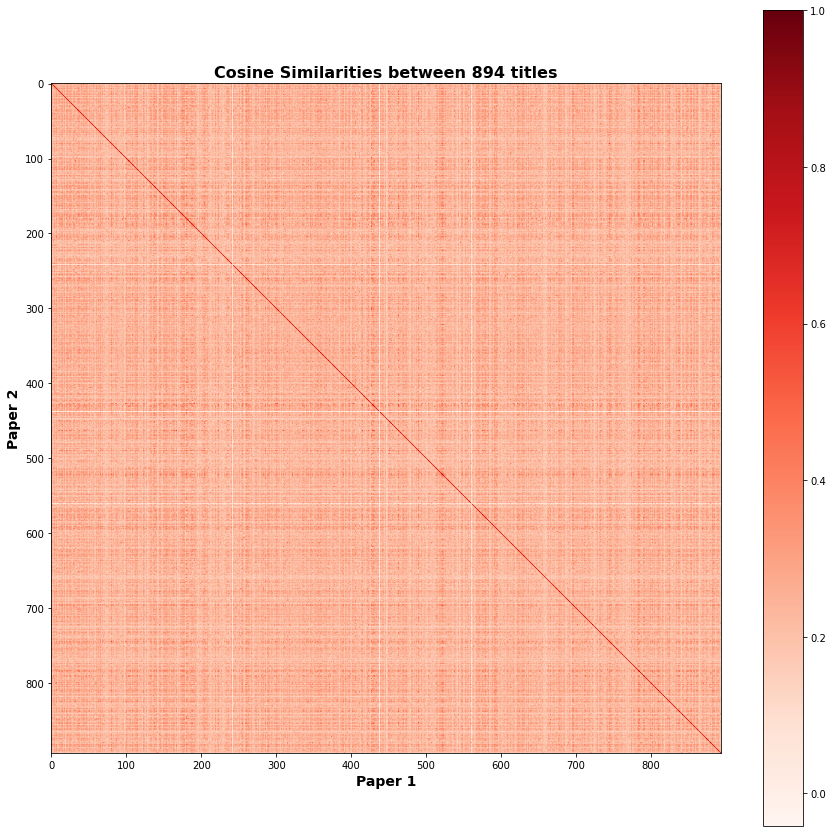

In [61]:
fig, ax = plt.subplots(figsize=(15,15))

ax.set_xlabel('Paper 1', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('Paper 2', fontsize = 14, fontweight = 'bold')
ax.set_title('Cosine Similarities between {0} titles'.format(len(similarity_matrix)), fontsize = 16, fontweight = "bold")
heatmap = ax.imshow(similarity_matrix, cmap='Reds')
fig.colorbar(heatmap, ax=ax)

plt.show()

### Sequential method

Let us try to exploit some properties of the matrix, i.e.:
+ It is symmetric
+ Along the diagonal all terms are 1

And compute its elements, thus making a number of operations that is: $ \frac{N (N-1)}{2}$, and see which method performs better.

In [62]:
start_time = time.time()

cosine_matrix = np.eye(len(cosine_df),len(cosine_df))

for x in range(0, len(cosine_df)):
    for y in range(x): 
        val = cosine(cosine_df.embedding[x], cosine_df.embedding[y])
        cosine_matrix[x,y] = val
        cosine_matrix[y,x] = val

end_time = time.time()
print("CPU time taken to compute the cosine similarity matrix using sequential operations: [s] ", end_time - start_time)

CPU time taken to compute the cosine similarity matrix using sequential operations: [s]  301.55126214027405


In [63]:
np.savetxt('cosine_similarity_matrix.txt', cosine_matrix, delimiter = ',')  

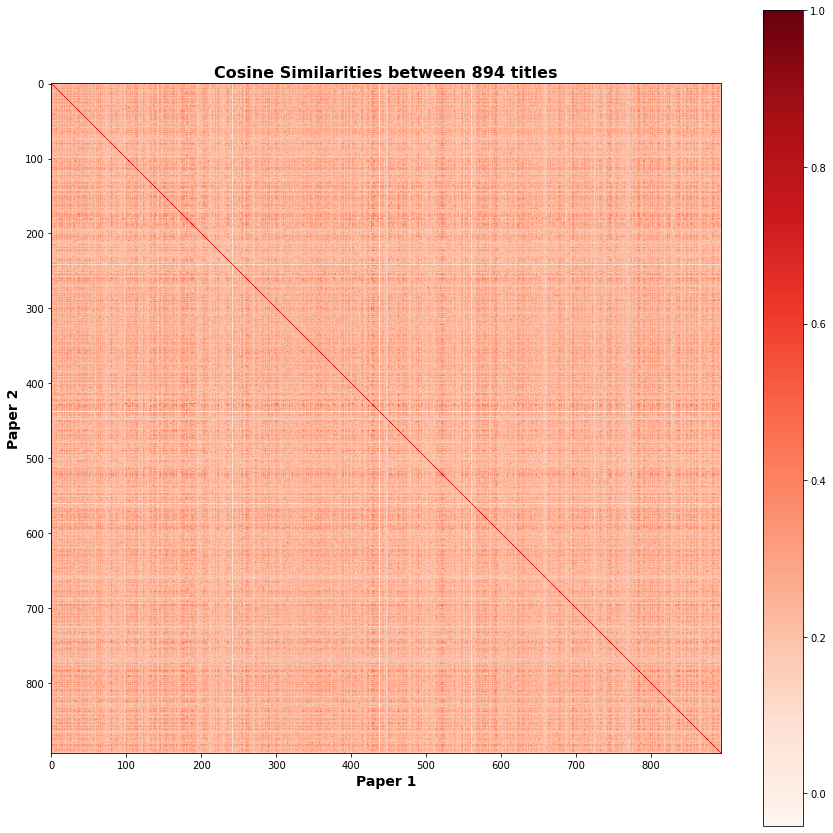

In [64]:
cosine_matrix = np.genfromtxt('cosine_similarity_matrix.txt', delimiter = ',') 
fig, ax = plt.subplots(figsize=(15,15))

ax.set_xlabel('Paper 1', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('Paper 2', fontsize = 14, fontweight = 'bold')
ax.set_title('Cosine Similarities between {0} titles'.format(len(cosine_matrix)), fontsize = 16, fontweight = "bold")
heatmap = ax.imshow(cosine_matrix, cmap='Reds')
fig.colorbar(heatmap, ax=ax)

plt.show()

Given that results are actually the same ones, however, we can see that despite we make $N^2$ operations using dask bags rather than $\frac{N(N-1)}{2}$, parallelizing the code results in a better time performance.

In [65]:
list_to_df = []
for x in range(1, len(cosine_df)):
    for y in range(x):
        val = cosine_matrix[x,y]
        list_to_df.append({'Paper1': cosine_df.paper_id[x] , 'Paper2': cosine_df.paper_id[y], 'cosine_similarity': val})

dask_dataframe = dd.from_pandas( pd.DataFrame(list_to_df), npartitions = 5 ).drop_duplicates(subset=['Paper1', 'Paper2'])
dask_dataframe.head()

Paper1  \
0  000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a   
1  000b0174f992cb326a891f756d4ae5531f2845f7   
2  000b0174f992cb326a891f756d4ae5531f2845f7   
3  000b7d1517ceebb34e1e3e817695b6de03e2fa78   
4  000b7d1517ceebb34e1e3e817695b6de03e2fa78   

                                     Paper2  cosine_similarity  
0  000a0fc8bbef80410199e690191dc3076a290117           0.374750  
1  000a0fc8bbef80410199e690191dc3076a290117           0.283110  
2  000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a           0.300200  
3  000a0fc8bbef80410199e690191dc3076a290117           0.246329  
4  000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a           0.271250

Let us now retrieve the 20 papers whose titles have the largest cosine similarity:

In [66]:
top = dask_dataframe.nlargest(20, 'cosine_similarity').reset_index(drop = True).compute()
top

Paper1  \
0   0c16cef2ddd3e7251855e473620b50def7520b80   
1   0bbfbaaf1a302da40204fe62e192ac839218b0e9   
2   0c916b643c9a58ad9c31e3674112c3309d191394   
3   0b91de43ac98c1f8e4bcc8f56f95b9f91904ac20   
4   0c9f9d3d11ca8db0ce4abe3563a077a7b84aac19   
5   0c1d950cd4ef4b3ea5ddbdb1d57718a9ab49a068   
6   0c1d950cd4ef4b3ea5ddbdb1d57718a9ab49a068   
7   0ba67ac74fbf969ba63867a3e7992ed5adbaa4c3   
8   0c916b643c9a58ad9c31e3674112c3309d191394   
9   0c4033ddab612dff901774a50604eac27bcb8f8b   
10  0d3b945d04dc343fec0b31ceda717f31155a8795   
11  0cd389be1501d7f0943e5078cf951249c95de0f5   
12  0b05d3ede3351f8b3edb22c74b0cfe933ba408c1   
13  0baffdf3900302d1a91c63f7a634fff20b34e302   
14  0a789f33c09c431e21a5647178d0439fdb8689aa   
15  0c9397119cdbc9f41868f17e7d28e3ea91aa3666   
16  0adbf9d3e4a2ca61b0bbaf594355ca4358a69023   
17  0a7822e6d84496c45d76ef6ddafa41140f866fae   
18  0d0f7eed67d2f1cbf26b7a4c8252b206fb7d7c9f   
19  0b91de43ac98c1f8e4bcc8f56f95b9f91904ac20   

                                      Paper2  cosine_similarity  
0   0ac2dcedb0154464c73007929ef34a17a92e0e84           1.000000  
1   0a4be9f048521079c802d449143d88bbb140c230           1.000000  
2   0a1ca73dc5f51aaecd0a451d8031316252603664           0.976481  
3   0a6e4bc983e7a8eb31e252398f47cdaaf1e605b1           0.919242  
4   0adbf9d3e4a2ca61b0bbaf594355ca4358a69023           0.891612  
5   0aefcfb7f8f424c21f70dbb39518ea15fa9f01cb           0.832688  
6   0a2951a64506e15068b565d3b8e28ade7d27dc0a           0.814520  
7   0b71c286d446269acaefbfa63e64125241ed3efb           0.808558  
8   0c36cc3dc9a1632f0fbf14372f376f89521718c5           0.804078  
9   0b91de43ac98c1f8e4bcc8f56f95b9f91904ac20           0.797798  
10  0adbf9d3e4a2ca61b0bbaf594355ca4358a69023           0.771436  
11  0adbf9d3e4a2ca61b0bbaf594355ca4358a69023           0.764626  
12  0ad3da313db27e490fcecf58a7e5ddd248076144           0.759167  
13  0a787237a52b050f9ac0b2100272f8adf0ade472           0.758296  
14  0a787237a52b050f9ac0b2100272f8adf0ade472           0.751578  
15  0a787237a52b050f9ac0b2100272f8adf0ade472           0.746665  
16  0ac3fd7c906edf9eecef4c6d7a3b5fc3d3546ec0           0.737866  
17  00c55b10995c68a91b0aaa361334d0f60195cf63           0.735466  
18  0b28a146cc0e0248796c5d0d50ded897ddaa0546           0.733984  
19  0b5f8aa815f121c29d72e06b6fa8f1e1f7baa64c           0.733565

In [67]:
def print_paper_titles_and_cosine(df, index, hash1, hash2, cosine_val):
    print("\n")
    print("Paper 1 has title: ", df.title[df.paper_id == hash1].values)
    print("Paper 2 has title: ", df.title[df.paper_id == hash2].values)
    print("Cosine similarity: ", cosine_val)
    print("\n")

In [68]:
for paper_index in range(len(top)):
    print_paper_titles_and_cosine(cosine_df, paper_index,
                                  top.Paper1[paper_index], top.Paper2[paper_index],
                                  top.cosine_similarity[paper_index])



Paper 1 has title:  ['WORKSHEET for EvidenceBased Review of Science for Emergency Cardiac Care Worksheet author(s) ith Professor Gary B Sm plett ini']
Paper 2 has title:  ['WORKSHEET for Evidence-Based Review of Science for Emergency Cardiac Care Worksheet author(s)']
Cosine similarity:  1.0




Paper 1 has title:  ['To appear in: Public Health']
Paper 2 has title:  ['To appear in: Public Health in Practice']
Cosine similarity:  0.9999999999999998




Paper 1 has title:  ['Respiratory viral infections']
Paper 2 has title:  ['RESPIRATORY VIRAL INFECTION AND ASTHMA']
Cosine similarity:  0.9764812804169932




Paper 1 has title:  ['CYSTEINE PROTEASES']
Paper 2 has title:  ['Membrane-anchored serine proteases in health and disease']
Cosine similarity:  0.9192418364598893




Paper 1 has title:  ['Immunomodulatory therapy for the management of severe COVID-19. Beyond the anti-viral therapy: A comprehensive review']
Paper 2 has title:  ['368 ANTIVIRAL THERAPY (NON-HIV)']
Cosine similarity:

# Timing analysis

Let us compare now the results we obtained using different clusters for the first two parts of the assignment:
+ **Remote Cluster**: number of workers were changed from 5 through 1, and by changing the number of partitions. Every worker had 4 threads each and the number of partitions was chosen among $\{1,2,5,10,25,50,100,250,500,1000\}$.
+ **Local Cluster**: a local cluster, with exactly the same characteristics as the Remote one. ($N_{workers} = \{5,4,3,2,1\}$), 4 threads each and same set of possible number of partitions. 
+ **Best Local Cluster**: a local cluster that exploits all the resources available on the laptop, namely 32 *total threads* split among 1,2,4,8,16,32 different workers and same set of number of partitions as before.

Our previsions could be that the **Remote** cluster would be perform *worse* rather than **Local** and the **Best Local**, since for a given number of workers, the latency experienced by sending/collecting work to/from workers that sit on different virtual machines we expect to play a role.

However, we will see as this is exactly *the opposite* for tasks with less amount of data.

In [2]:
n_workers_list = [1,2,3,4,5]
first_times_df_list = []
second_times_df_list = []

for n_work in n_workers_list:
    first_times_df_list.append(pd.read_csv("data_to_be_analyzed/times_first_df_"+str(n_work)+"Workers.csv", 
                                           dtype = {'n_partitions' : int, 'n_workers' : int, 'time' : float }))
    second_times_df_list.append(pd.read_csv("data_to_be_analyzed/times_second_df_"+str(n_work)+"Workers.csv", 
                                           dtype = {'n_partitions' : int, 'n_workers' : int, 'time' : float }))
    
remote_df_first     = pd.concat(first_times_df_list).reset_index(drop = True)
local_df_first      = pd.read_csv("times_first_df.csv", dtype = {'n_partitions' : int, 'n_workers' : int, 'time' : float })
local_df_first_same = pd.read_csv("times_first_df_same_conditions.csv", dtype = {'n_partitions' : int, 'n_workers' : int, 'time' : float })

remote_df_second = pd.concat(second_times_df_list).reset_index(drop = True)
local_df_second  = pd.read_csv("times_second_df.csv", dtype = {'n_partitions' : int, 'n_workers' : int, 'time' : float })
local_df_second_same = pd.read_csv("times_second_df_same_conditions.csv", dtype = {'n_partitions' : int, 'n_workers' : int, 'time' : float })

In [3]:
#compute the minimum and maximum values, in order to "set the scale" of the heatmaps, to compare in a better way the timings
v_min_1_same = min(min(remote_df_first.time), min(local_df_first_same.time))
v_max_1_same = max(max(remote_df_first.time), max(local_df_first_same.time))
v_min_1 = min(min(remote_df_first.time), min(local_df_first.time), min(local_df_first_same.time))
v_max_1 = max(max(remote_df_first.time), max(local_df_first.time), max(local_df_first_same.time))


v_min_2_same = min(min(remote_df_second.time), min(local_df_second_same.time))
v_max_2_same = max(max(remote_df_second.time), max(local_df_second_same.time))
v_min_2 = min(min(remote_df_second.time), min(local_df_second.time), min(local_df_second_same.time))
v_max_2 = max(max(remote_df_second.time), max(local_df_second.time), max(local_df_second_same.time))

In [4]:
#Visualization functions
def get_best_performance(dataset, string = ""):
    min_val = min(dataset.time)
    min_index = dataset.index[dataset.time == min_val]
    min_row =  dataset.iloc[min_index,:]
    print("For cluster :", string, " the best performance was achieved with: ")
    print("N Workers: ", min_row.n_workers.values[0], "\t N partitions: ", min_row.n_partitions.values[0], "\t and took [s]: ", min_row.time.values[0])
    return #min_row

def plot_times_vs_workers(dataset, string = ""):
    n_workers_list = list(dataset.n_workers.unique())
    sns.set_palette('magma', len(n_workers_list))
    
    fig = plt.figure(figsize = (8,6))

    for n_work in n_workers_list:
        subset_df = dataset[dataset['n_workers'] == n_work]
        plt.plot(subset_df.n_partitions, subset_df.time, label = str(n_work))
    
    plt.xlabel("Number of partitions")
    plt.ylabel("Time [s]")
    plt.legend(title = "Workers")
    plt.title("CPU Time [s] - "+ string)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    return

def plot_times_vs_partitions(dataset, string = ""):
    n_partitions_list = list(dataset.n_partitions.unique())
    sns.set_palette('magma', len(n_partitions_list))
    fig = plt.figure(figsize = (8,6))
    for n_part in n_partitions_list:
        subset_df = dataset[dataset['n_partitions'] == n_part]
        plt.plot(subset_df.n_workers, subset_df.time, label = str(n_part))

    plt.xlabel("Number of workers")
    plt.ylabel("Time [s]")
    plt.legend(title = "Partitions")
    plt.title("CPU Time [s] - "+ string)
    plt.show()
    
    return

def plot_times_given_cluster(dataset, string = ""):
    n_partitions_list = list(dataset.n_partitions.unique())
    n_workers_list = list(dataset.n_workers.unique())
    sns.set_palette('magma', len(n_partitions_list))
    
    fig = plt.figure(figsize = (12,6))
    plt.subplot(1, 2, 1)
    
    for n_work in n_workers_list:
        subset_df = dataset[dataset['n_workers'] == n_work]
        plt.plot(subset_df.n_partitions, subset_df.time, label = str(n_work))
        
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of partitions")
    plt.ylabel("Time [s]")
    plt.legend(title = "Workers")
    plt.title("CPU Time [s] - "+ string)
    
    plt.subplot(1, 2, 2)
    
    for n_part in n_partitions_list:
        subset_df = dataset[dataset['n_partitions'] == n_part]
        plt.plot(subset_df.n_workers, subset_df.time, label = str(n_part))

    plt.xlabel("Number of workers")
    plt.ylabel("Time [s]")
    plt.legend(title = "Partitions")
    plt.title("CPU Time [s] - "+ string)
    
    plt.show()
    return

# First part of the assignment

**Word counter distributed algorithm**

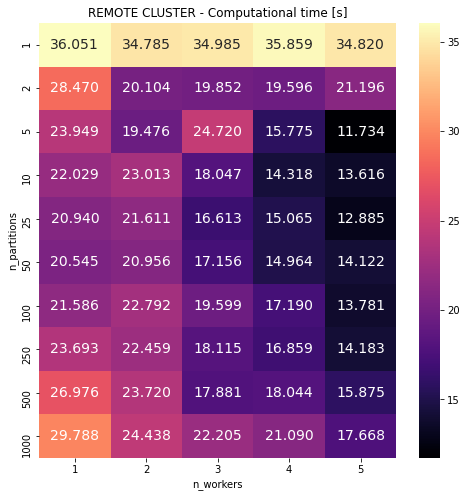

In [5]:
#heatmap code
plt.figure(figsize = (8,8))
heatmap_data_rem = pd.pivot_table(remote_df_first, values='time', 
                     index=['n_partitions'], 
                     columns='n_workers')
sns.heatmap(heatmap_data_rem, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f")
plt.title("REMOTE CLUSTER - Computational time [s]")
plt.show()

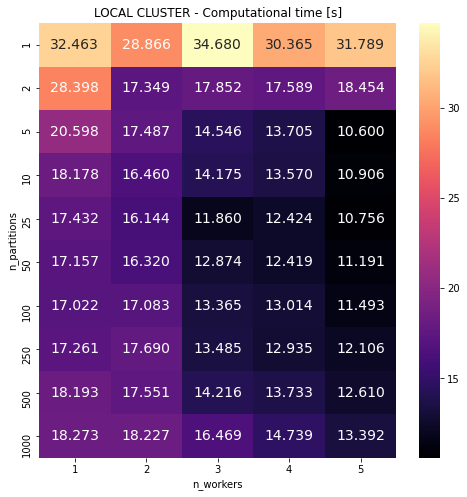

In [6]:
### THIS DATA has the same parameters of the cluster run remotely (i.e. 4 threads per worker, same "n_partitions vs n_worker" set)

#heatmap code
plt.figure(figsize = (8,8))
heatmap_data_loc = pd.pivot_table(local_df_first_same, values='time', 
                     index=['n_partitions'], 
                     columns='n_workers')
sns.heatmap(heatmap_data_loc, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f")
plt.title("LOCAL CLUSTER - Computational time [s]")
plt.show()

Let us compare which cluster behaves better, between the remote and local, provided an equal amount of resources.

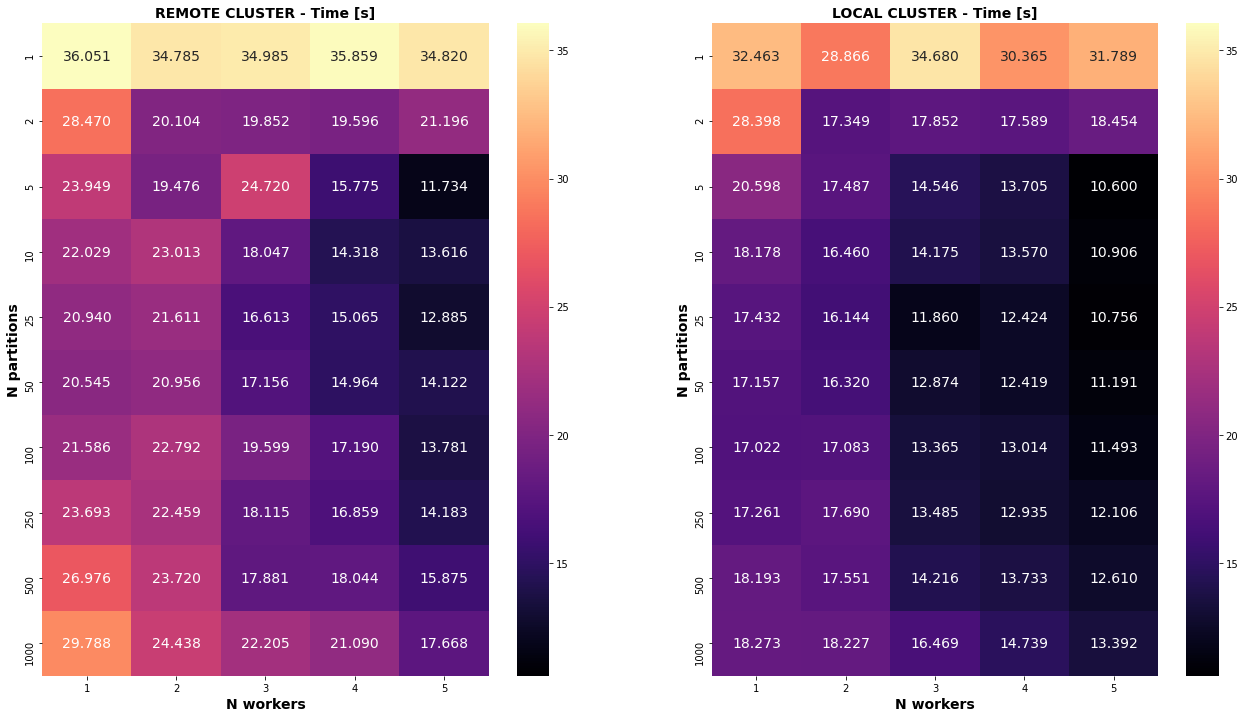

In [7]:
fig, ax  = plt.subplots(1, 2, figsize=(22, 12))
sns.heatmap(heatmap_data_rem, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_1_same, vmax=v_max_1_same, ax = ax[0])
sns.heatmap(heatmap_data_loc, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_1_same, vmax=v_max_1_same, ax = ax[1])

ax[0].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[0].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[0].set_title("REMOTE CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
ax[1].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[1].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[1].set_title("LOCAL CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
plt.show()

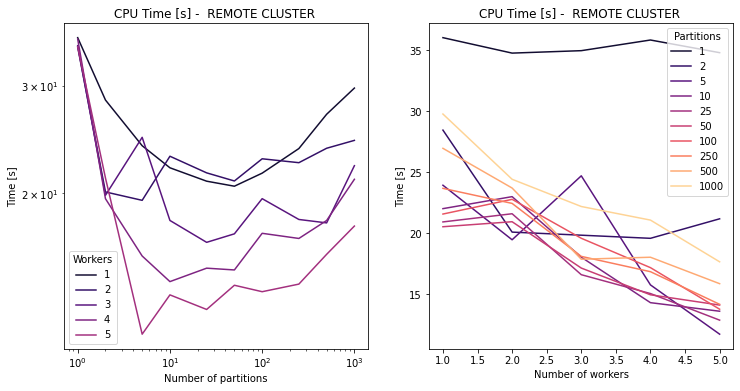

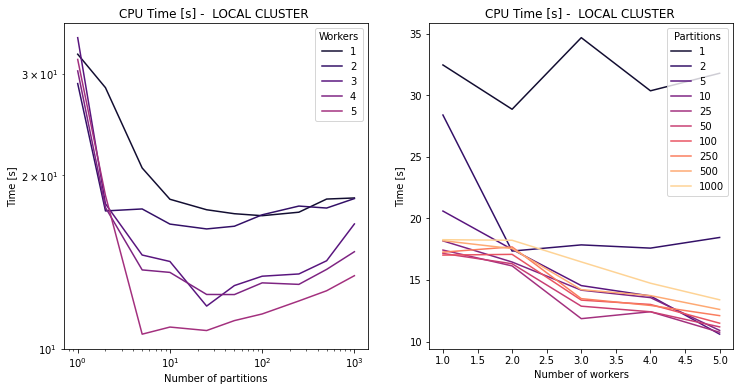

In [8]:
plot_times_given_cluster(remote_df_first, " REMOTE CLUSTER ")
plot_times_given_cluster(local_df_first_same, " LOCAL CLUSTER ")

In [9]:
get_best_performance(remote_df_first, " REMOTE CLUSTER ")
print("\n")
get_best_performance(local_df_first_same, " LOCAL CLUSTER ")

For cluster :  REMOTE CLUSTER   the best performance was achieved with: 
N Workers:  5 	 N partitions:  5 	 and took [s]:  11.73426365852356


For cluster :  LOCAL CLUSTER   the best performance was achieved with: 
N Workers:  5 	 N partitions:  5 	 and took [s]:  10.6003155708313


Now we attempt a **Vertical scaling**: to make our cluster more powerful, thus exploiting all the resources available.  

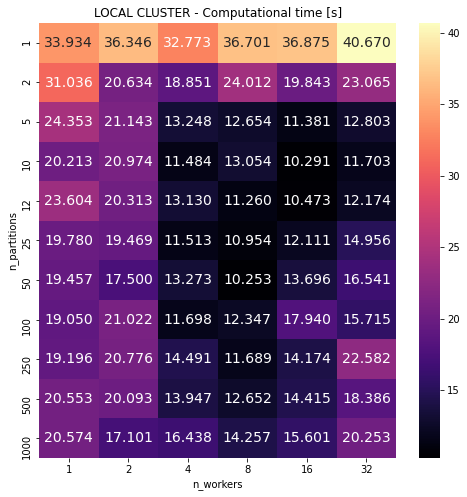

In [10]:
### VERTICAL SCALING attempt: we use a local cluster, but exploiting all the threads (i.e. 32) available on a laptop

#heatmap code
plt.figure(figsize = (8,8))
heatmap1_data = pd.pivot_table(local_df_first, values='time', 
                     index=['n_partitions'], 
                     columns='n_workers')
sns.heatmap(heatmap1_data, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f")
plt.title("LOCAL CLUSTER - Computational time [s]")
plt.show()

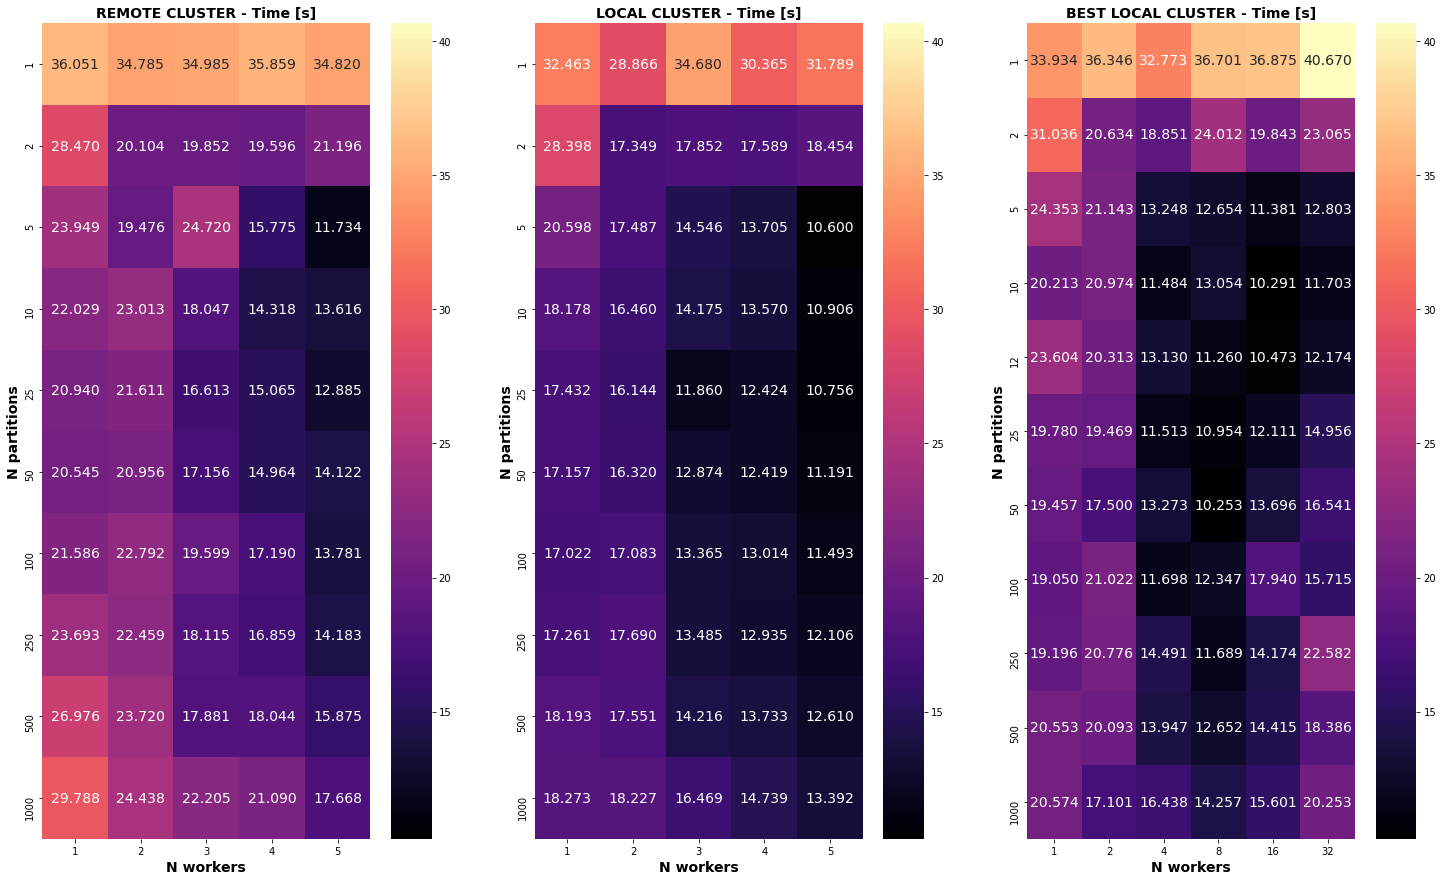

In [23]:
fig, ax  = plt.subplots(1, 3, figsize=(25, 15))
sns.heatmap(heatmap_data_rem, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_1, vmax=v_max_1, ax = ax[0])
sns.heatmap(heatmap_data_loc, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_1, vmax=v_max_1, ax = ax[1])
sns.heatmap(heatmap1_data, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_1, vmax=v_max_1, ax = ax[2])

ax[0].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[0].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[0].set_title("REMOTE CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
ax[1].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[1].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[1].set_title("LOCAL CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
ax[2].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[2].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[2].set_title("BEST LOCAL CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
plt.show()

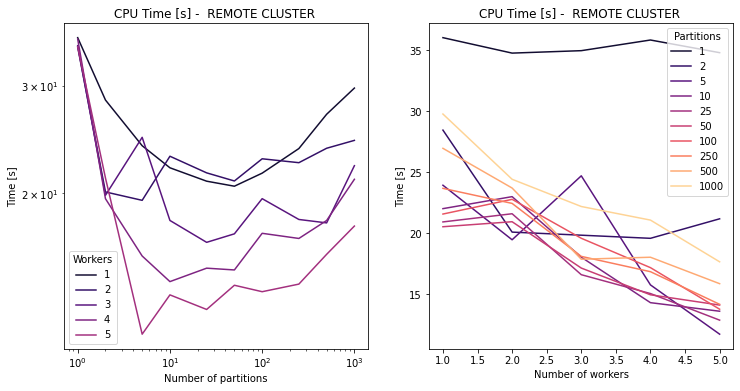

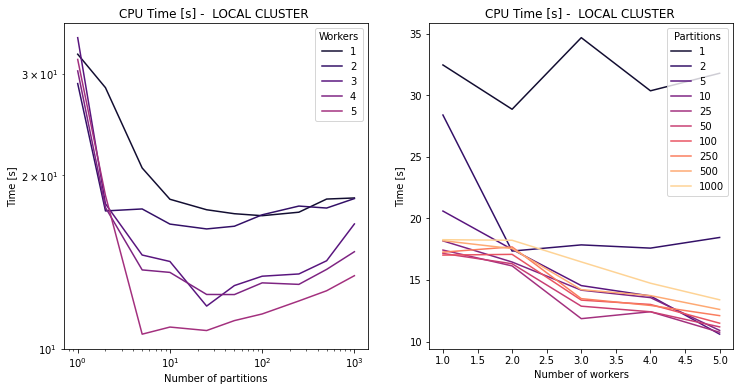

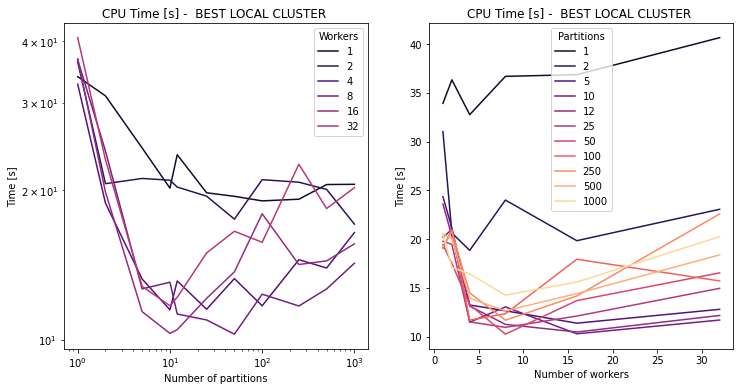

In [11]:
plot_times_given_cluster(remote_df_first, " REMOTE CLUSTER ")
plot_times_given_cluster(local_df_first_same, " LOCAL CLUSTER ")
plot_times_given_cluster(local_df_first, " BEST LOCAL CLUSTER ")

In [12]:
get_best_performance(remote_df_first, " REMOTE CLUSTER ")
print("\n")
get_best_performance(local_df_first_same, " LOCAL CLUSTER ")
print("\n")
get_best_performance(local_df_first, " BEST LOCAL CLUSTER ")

For cluster :  REMOTE CLUSTER   the best performance was achieved with: 
N Workers:  5 	 N partitions:  5 	 and took [s]:  11.73426365852356


For cluster :  LOCAL CLUSTER   the best performance was achieved with: 
N Workers:  5 	 N partitions:  5 	 and took [s]:  10.6003155708313


For cluster :  BEST LOCAL CLUSTER   the best performance was achieved with: 
N Workers:  8 	 N partitions:  50 	 and took [s]:  10.25324320793152


Here, we can see that the local cluster given a fixed amount of resources performs better that the remote one. It is interesting to note that the optimal number of workers is the largest we could have, namely 5, every worker dealing with a single partitions.

However, when scaling vertically thus increasing the power of the hardware, the optimal number of workers is 8 (resulting in a $32/8 = 4\ threads$), every worker having $50/8 \approx 6$ partitions each. One should also take into account that the total number of threads was maximally fixed to 32.

This is what we would actually expect from our previsions. 

# Second part of the assignment

**Which are the worst and best represented countries in the research?**

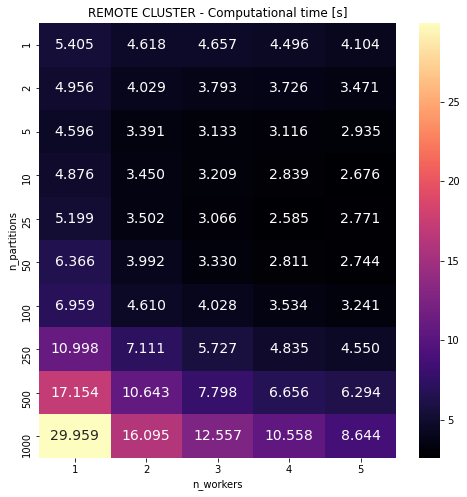

In [13]:
#heatmap code
plt.figure(figsize = (8,8))
heatmap_data_rem2 = pd.pivot_table(remote_df_second, values='time', 
                     index=['n_partitions'], 
                     columns='n_workers')
sns.heatmap(heatmap_data_rem2, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f")
plt.title("REMOTE CLUSTER - Computational time [s]")
plt.show()

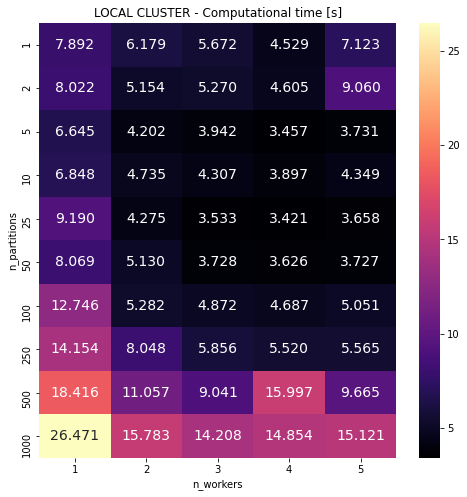

In [14]:
### THIS DATA has the same parameters of the cluster run remotely (i.e. 4 threads per worker, same "n_partitions vs n_worker" set)

#heatmap code
plt.figure(figsize = (8,8))
heatmap_data_loc2 = pd.pivot_table(local_df_second_same, values='time', 
                     index=['n_partitions'], 
                     columns='n_workers')
sns.heatmap(heatmap_data_loc2, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f")
plt.title("LOCAL CLUSTER - Computational time [s]")
plt.show()

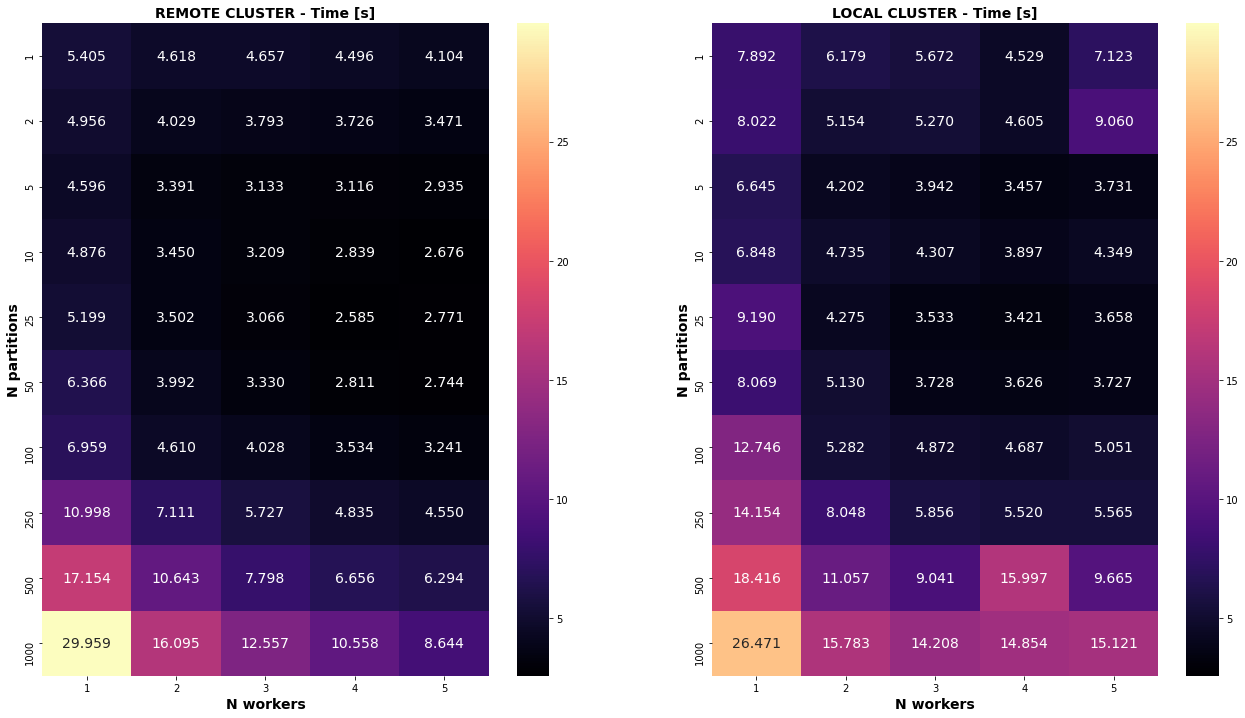

In [15]:
fig, ax  = plt.subplots(1, 2, figsize=(22, 12))
sns.heatmap(heatmap_data_rem2, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_2_same, vmax=v_max_2_same, ax = ax[0])
sns.heatmap(heatmap_data_loc2, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_2_same, vmax=v_max_2_same, ax = ax[1])

ax[0].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[0].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[0].set_title("REMOTE CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
ax[1].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[1].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[1].set_title("LOCAL CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
plt.show()

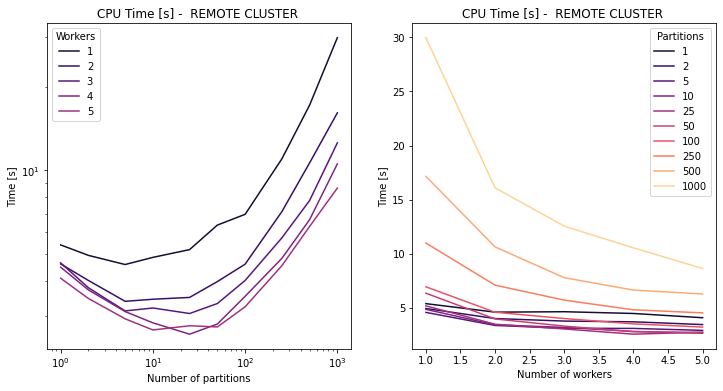

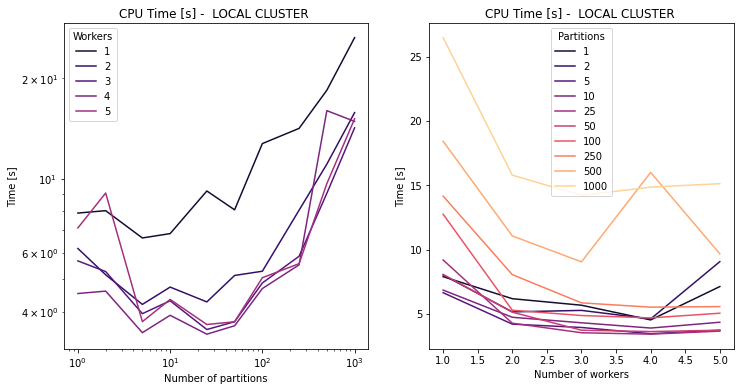

In [16]:
plot_times_given_cluster(remote_df_second, " REMOTE CLUSTER ")
plot_times_given_cluster(local_df_second_same, " LOCAL CLUSTER ")

In [17]:
get_best_performance(remote_df_second, " REMOTE CLUSTER ")
print("\n")
get_best_performance(local_df_second_same, " LOCAL CLUSTER ")

For cluster :  REMOTE CLUSTER   the best performance was achieved with: 
N Workers:  4 	 N partitions:  25 	 and took [s]:  2.5847506523132324


For cluster :  LOCAL CLUSTER   the best performance was achieved with: 
N Workers:  4 	 N partitions:  25 	 and took [s]:  3.4213037490844727


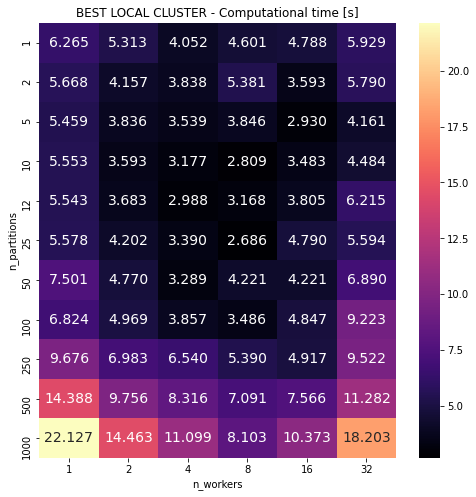

In [24]:
### VERTICAL SCALING attempt: we use a local cluster, but exploiting all the threads (i.e. 32) available on a laptop

plt.figure(figsize = (8,8))
heatmap2_data = pd.pivot_table(local_df_second, values='time', 
                     index=['n_partitions'], 
                     columns='n_workers')
sns.heatmap(heatmap2_data, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f")
plt.title("BEST LOCAL CLUSTER - Computational time [s]")
plt.show()

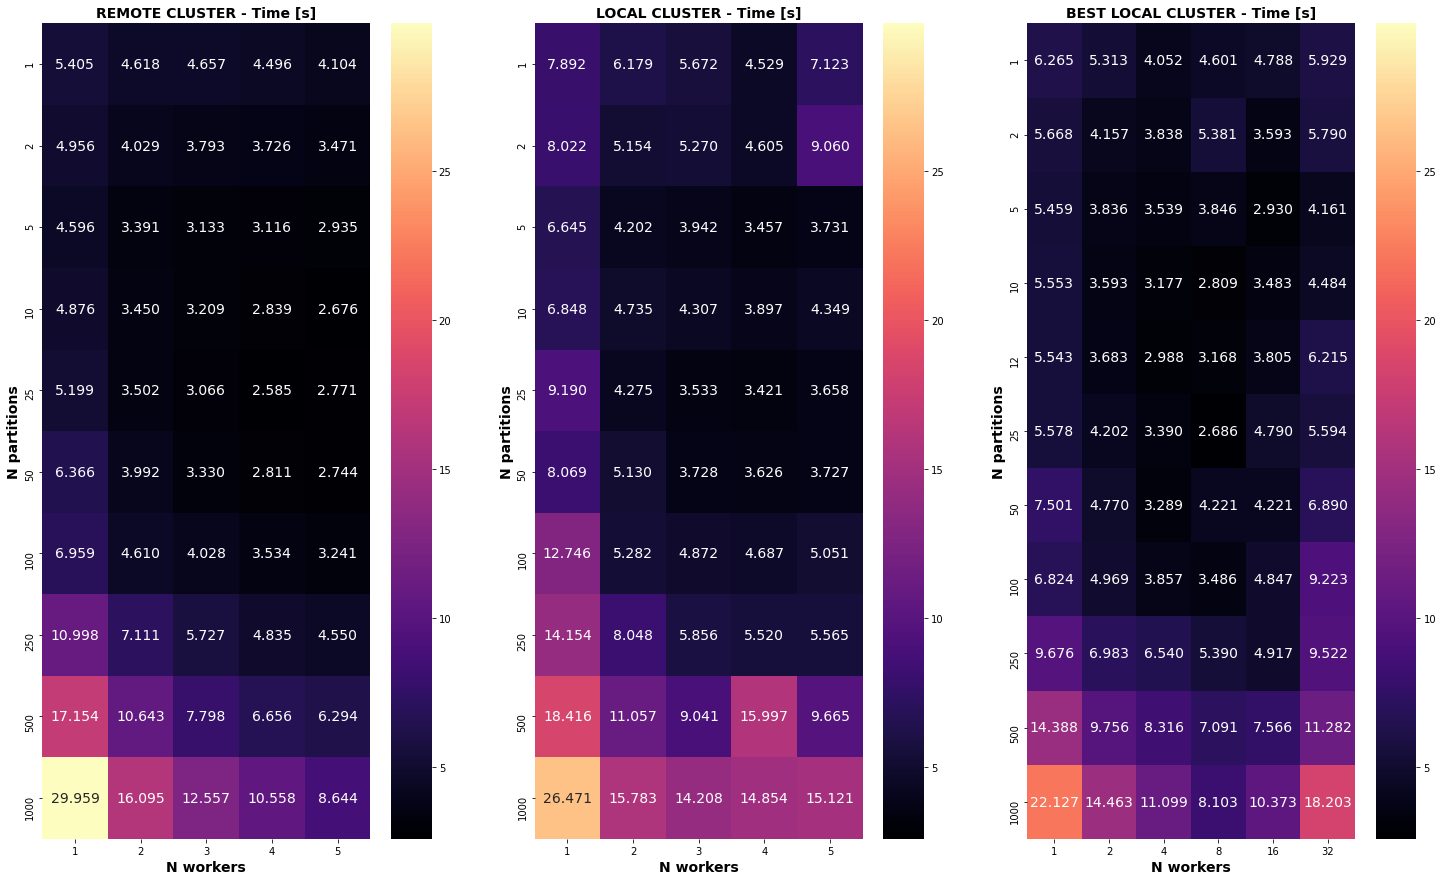

In [19]:
fig, ax  = plt.subplots(1, 3, figsize=(25, 15))
sns.heatmap(heatmap_data_rem2, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_2, vmax=v_max_2, ax = ax[0])
sns.heatmap(heatmap_data_loc2, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_2, vmax=v_max_2, ax = ax[1])
sns.heatmap(heatmap2_data, cmap="magma", annot=True, annot_kws={"size": 14}, fmt=".3f", vmin=v_min_2, vmax=v_max_2, ax = ax[2])

ax[0].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[0].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[0].set_title("REMOTE CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
ax[1].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[1].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[1].set_title("LOCAL CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
ax[2].set_xlabel('N workers', fontsize = 14, fontweight = 'bold')
ax[2].set_ylabel('N partitions', fontsize = 14, fontweight = 'bold')
ax[2].set_title("BEST LOCAL CLUSTER - Time [s]", fontweight = 'bold', fontsize = 14)
plt.show()

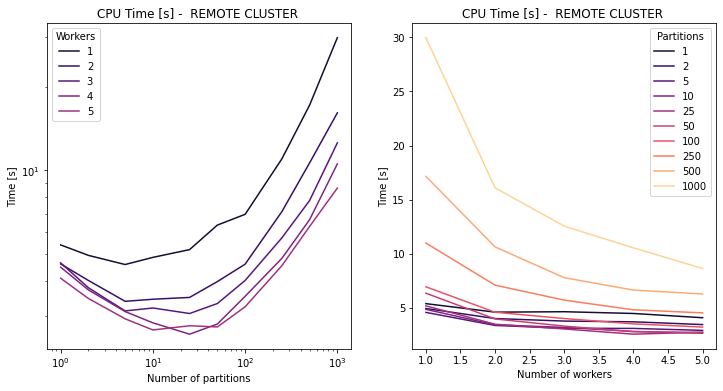

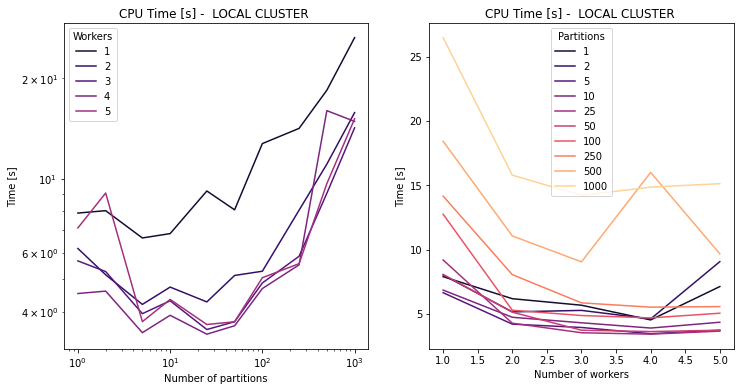

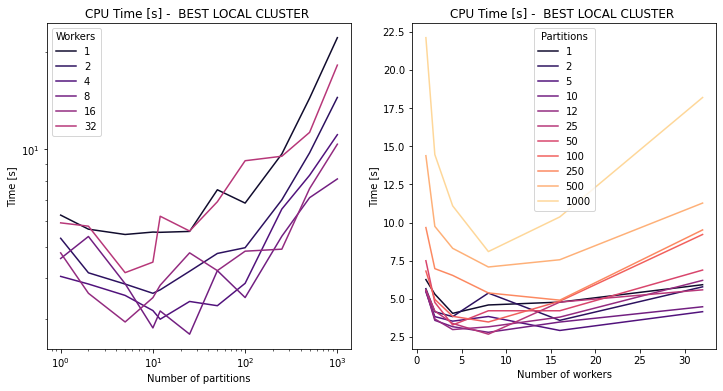

In [20]:
plot_times_given_cluster(remote_df_second, " REMOTE CLUSTER ")
plot_times_given_cluster(local_df_second_same, " LOCAL CLUSTER ")
plot_times_given_cluster(local_df_second, " BEST LOCAL CLUSTER ")

In [21]:
get_best_performance(remote_df_second, " REMOTE CLUSTER ")
print("\n")
get_best_performance(local_df_second_same, " LOCAL CLUSTER ")
print("\n")
get_best_performance(local_df_second, " BEST LOCAL CLUSTER ")

For cluster :  REMOTE CLUSTER   the best performance was achieved with: 
N Workers:  4 	 N partitions:  25 	 and took [s]:  2.5847506523132324


For cluster :  LOCAL CLUSTER   the best performance was achieved with: 
N Workers:  4 	 N partitions:  25 	 and took [s]:  3.4213037490844727


For cluster :  BEST LOCAL CLUSTER   the best performance was achieved with: 
N Workers:  8 	 N partitions:  25 	 and took [s]:  2.6864168643951416


Here things start to be more interesting: the optimal number of partitions is 25 for every kind of cluster, though in the **BEST LOCAL** one this would result in a less number of partitions per workers ($25/8 \approx 3$ vs $25/4 \approx 6$). For the same amount of resources, the optimal number of workers is the same one, even though it is not the largest number allowed: indeed the optimal number of workers is 4, while the maximum is 5.

However, as we would expect the local custer with the largest amount of resources performs better than the other local one, though surprisingly performing slightly worse than the **REMOTE** one. Moreover, here the optimal amount of workers is not the largest number we could have. This can be interpreted as a sort of trade off: the largest the number of workers, the more work the scheduler has to do to split the job, thus increasing the overhead.

#### Conclusions

A possible explanation for such behaviours is that: the more intensive the tasks, the larger the number of the workers needed. Indeed the first part of the assignment (NLP) generally took more time, and required more transfer of data, whereas the second one, which mainly dealt only with metadata field, is expected to be less intensive.  


Finally one could note that curves representing CPU time vs different hyperparameters of the clusters are much more noisy in the local clusters instances, despite the trend being the same for both cases.

A possible explanation for this would be the different processors and maybe the virtualization of the environment:
+ **LOCAL CLUSTER**: exploits the Windows `wsl` environment, built on Docker. This alongwith the presence of UI might have lead to some waste of resources, which is not present on server side. Indeed Jupyter notebook, running on Chrome, needs some resources to be working. Moreover, the [processor](https://ark.intel.com/content/www/us/en/ark/products/208018/intel-core-i7-10870h-processor-16m-cache-up-to-5-00-ghz.html) being a *mobile* one *Intel(R) Core(TM) i7-10870H CPU @ 2.20GHz* with 16 cores and 32 threads, so not as powerful as a desktop/cluster one.
+ **REMOTE CLUSTER**: ubuntu here is run without any UI. The [processor](https://ark.intel.com/content/www/us/en/ark/products/199345/intel-xeon-gold-6238r-processor-38-5m-cache-2-20-ghz.html) being a *Intel(R) Xeon(R) Gold 6238R CPU @ 2.20GHz*, specifically designed for servers and having 28 cores and 56 threads. The orchestration of the containers, as far we understood, occurs with Kubernetes, which is know to perform optimally with clusters and eventually this aspect might play a role. 

Finally, it is interesting to notice as in the third part of the assignment, despite the number of operations was almost $\approx 1/4$ with respect to the distributed algorithm, the sequential way of proceeding took much more timeas one might expect. That is to say that the code shall be parallelized when possible. 